In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time
import datetime

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

from enhancer_gene_hic_validation_utils import *

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS
today = datetime.date.today()
print(today)

2020-12-07


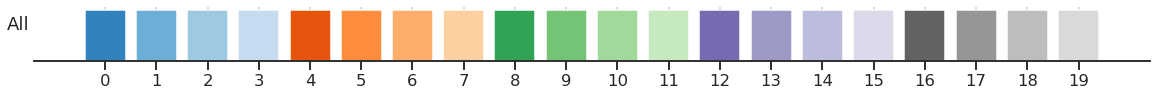

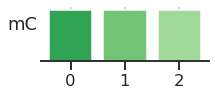

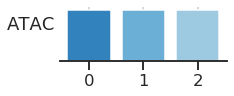

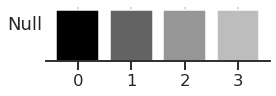

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000

# def p25(x):
#     return np.percentile(x, 25)
# def p75(x):
#     return np.percentile(x, 75)

In [5]:
chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000


celltype = 'L2_3'
chromosome = 'chr1'

# search for the most contacted pairs of all linked pairs

In [6]:
df_genes = pd.read_csv(GENEBODY, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gid')
df_genes.head()

,gene_id,gene_name,chr,start,end,strand,gene_type
gid,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [7]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list
# orig significant pairs (enh_index and gid)
f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv'
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv'
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv'
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv'
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

linked_pairs_mc.head()

(126134, 5)
(33814, 4)
(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)


,gene,enh,dist
0,ENSMUSG00000000058,181997,14555
1,ENSMUSG00000000088,221978,48225
2,ENSMUSG00000000126,35942,90017
3,ENSMUSG00000000126,35953,4552
4,ENSMUSG00000000126,35954,5567


In [8]:
linked_pairs_both = pd.merge(linked_pairs_mc, linked_pairs_atac, on=['gene', 'enh', 'dist'])
correlated_pairs_both = pd.merge(correlated_pairs_mc, correlated_pairs_atac, on=['gene', 'enh', 'dist'])
print(linked_pairs_both.shape, 
      correlated_pairs_both.shape, 
     )

(1268, 3) (35309, 3)


In [9]:
# gene expression profiles
f = '/sphere/fangming/enhancers/scripts/data_organized/gene_rna_clsts.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [10]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}

def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)
clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [11]:
# merge RNA profiles
_tmp = gene_rna_clsts.T
_tmp['annot'] = clst_annot_broad.loc[_tmp.index]
gene_rna_clsts_broad = _tmp.groupby('annot').median().T
gene_rna_clsts_broad_rank = gene_rna_clsts_broad.rank(pct=True, axis=1)
print(gene_rna_clsts_broad_rank.shape)
gene_rna_clsts_broad_rank.head()

(12095, 8)


annot,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
ENSMUSG00000000001,0.500,0.750,0.250,0.625,0.875,0.125,0.375,1.000
ENSMUSG00000000056,0.125,0.750,0.875,0.500,0.625,1.000,0.250,0.375
ENSMUSG00000000058,0.625,1.000,0.250,0.375,0.750,0.125,0.500,0.875
ENSMUSG00000000078,0.250,1.000,0.625,0.750,0.125,0.500,0.875,0.375
ENSMUSG00000000085,0.250,0.125,0.625,0.375,0.875,0.500,0.750,1.000


In [12]:
active_th = 0.5
# distances
distance_cutoff = 1e5
distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
distances = distance_idx * resolution

resolution = 10000
# celltype = "L2_3"
# chromosome = "chr1"

# get a list of candidate pairs
candidates_pair_all = []
    
for celltype in tqdm.tqdm(celltypes):
    for chromosome in tqdm.tqdm(chromosomes):
        # read in the matrix 
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        # all enhancers and tss on that chromosomes
        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]
        # only include the gene if it is actively expressed (>50% across cell types)
        active_genes = gene_rna_clsts_broad_rank[gene_rna_clsts_broad_rank[celltype]>active_th].index.values
        tsss = tsss[tsss['gid'].isin(active_genes)]

        # get paired bins
        paired_bin_tables = collections.OrderedDict({
        #     'linked_mc': enh_gene_id_to_binidx(linked_pairs_mc, tsss, enhs, resolution),
        #     'linked_atac': enh_gene_id_to_binidx(linked_pairs_atac, tsss, enhs, resolution),
            'linked_both': enh_gene_id_to_binidx(linked_pairs_both, tsss, enhs, resolution),
        #     'correlated_mc': enh_gene_id_to_binidx(correlated_pairs_mc, tsss, enhs, resolution),
        #     'correlated_atac': enh_gene_id_to_binidx(correlated_pairs_atac, tsss, enhs, resolution),
        #     'correlated_both': enh_gene_id_to_binidx(correlated_pairs_both, tsss, enhs, resolution),
        })
        track_names = list(paired_bin_tables.keys())

        # contact stats: distance bin by corr values in that bin
        (_contacts, _contacts_sig_pairs
        ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)

        # distance_idx starts from 1, not 0
        for i, (dist_idx, corr_bin_bck, corr_bin) in enumerate(zip(distance_idx, _contacts, _contacts_sig_pairs['linked_both'])):

            if len(corr_bin) > 0:
                contacts_p95 = np.nanpercentile(corr_bin_bck, 95)
                pairs = paired_bin_tables['linked_both'].loc[dist_idx].copy().reset_index() #[cond] 
                fc = corr_bin/contacts_p95
                pairs['fc'] = fc

                # contact frequency greater than 95 percentile in that distance bin
                candidates_pair = pairs[pairs['fc']>1].copy()
                candidates_pair['celltype'] = celltype
                candidates_pair_all.append(candidates_pair)
            
candidates_pair_all = pd.concat(candidates_pair_all, ignore_index=True)
print(candidates_pair_all.shape)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 432.78it/s]

  4%|▍         | 1/23 [00:04<01:49,  5.00s/it]

100%|██████████| 10/10 [00:00<00:00, 937.82it/s]

  9%|▊         | 2/23 [00:09<01:44,  4.98s/it]

100%|██████████| 10/10 [00:00<00:00, 1326.77it/s]

 13%|█▎        | 3/23 [00:13<01:29,  4.49s/it]

100%|██████████| 10/10 [00:00<00:00, 1147.49it/s]

 17%|█▋        | 4/23 [00:16<01:18,  4.11s/it]

100%|██████████| 10/10 [00:00<00:00, 495.55it/s]

 22%|██▏       | 5/23 [00:19<01:07,  3.75s/it]

100%|██████████| 10/10 [00:00<00:00, 1430.28it/s]

 26%|██▌       | 6/23 [00:22<00:58,  3.42s/it]

100%|██████████| 10/10 [00:00<00:00, 1434.29it/s]

 30%|███       | 7/23 [00:24<00:49,  3.07s/it]

100%|██████████| 10/10 [00:00<00:00, 618.82it/s]

 35%|███▍      | 8/23 [00:26<00:40,  2.73s/it]

100%|██████████| 10/10 [00:00<00:00, 1703.06it/s]

 39%|███▉      | 9/23 [00:28<00:34,  2.49s/it]

100%|██████████| 10/10 [00:00<00:00, 1517.75it/s]

 43%|████▎     | 10/23

 35%|███▍      | 8/23 [00:21<00:34,  2.27s/it]

100%|██████████| 10/10 [00:00<00:00, 1542.53it/s]

 39%|███▉      | 9/23 [00:23<00:28,  2.04s/it]

100%|██████████| 10/10 [00:00<00:00, 1556.04it/s]

 43%|████▎     | 10/23 [00:24<00:24,  1.86s/it]

100%|██████████| 10/10 [00:00<00:00, 1433.80it/s]

 48%|████▊     | 11/23 [00:26<00:21,  1.75s/it]

100%|██████████| 10/10 [00:00<00:00, 1506.52it/s]

 52%|█████▏    | 12/23 [00:27<00:17,  1.62s/it]

100%|██████████| 10/10 [00:00<00:00, 2244.98it/s]

 57%|█████▋    | 13/23 [00:28<00:14,  1.43s/it]

100%|██████████| 10/10 [00:00<00:00, 1647.15it/s]

 61%|██████    | 14/23 [00:29<00:11,  1.29s/it]

100%|██████████| 10/10 [00:00<00:00, 778.74it/s]

 65%|██████▌   | 15/23 [00:30<00:09,  1.18s/it]

100%|██████████| 10/10 [00:00<00:00, 2397.29it/s]

 70%|██████▉   | 16/23 [00:31<00:07,  1.05s/it]

100%|██████████| 10/10 [00:00<00:00, 2206.60it/s]

 74%|███████▍  | 17/23 [00:31<00:05,  1.06it/s]

100%|██████████| 10/10 [00:00<00:00, 2310.66it/s]

 78

 70%|██████▉   | 16/23 [00:33<00:07,  1.11s/it]

100%|██████████| 10/10 [00:00<00:00, 2266.21it/s]

 74%|███████▍  | 17/23 [00:34<00:05,  1.00it/s]

100%|██████████| 10/10 [00:00<00:00, 2019.89it/s]

 78%|███████▊  | 18/23 [00:35<00:04,  1.08it/s]

100%|██████████| 10/10 [00:00<00:00, 3350.08it/s]

 83%|████████▎ | 19/23 [00:35<00:03,  1.31it/s]

100%|██████████| 10/10 [00:00<00:00, 2554.23it/s]

 87%|████████▋ | 20/23 [00:36<00:02,  1.43it/s]

100%|██████████| 10/10 [00:00<00:00, 4510.49it/s]

 91%|█████████▏| 21/23 [00:36<00:01,  1.71it/s]

100%|██████████| 10/10 [00:00<00:00, 3591.01it/s]

 96%|█████████▌| 22/23 [00:36<00:00,  1.91it/s]

100%|██████████| 10/10 [00:00<00:00, 1827.66it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 995.56it/s]

  4%|▍         | 1/23 [00:04<01:35,  4.34s/it]

100%|██████████| 10/10 [00:00<00:00, 931.96it/s]

  9%|▊         | 2/23 [00:08<01:30,  4.30s/it]

100%|██████████| 10/10 [00:00<00:00, 1175.11it/s]

 13%|█▎      

(168, 15)


# Plot some examples

In [18]:
from matplotlib.patches import Rectangle
def plot_mat(mat_all, enh_bin, gene_bin, enh_name, gene_name):
    """
    """
    min_bin = min(enh_bin, gene_bin)
    max_bin = max(enh_bin, gene_bin)
    window = max_bin - min_bin
    pad = max(3, int(0.2*window))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{} {} (bin size={:,})".format(celltype, chromosome, resolution)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
                mat,
                cmap='rocket_r',
                cbar_kws={'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, 
                          'pad': 0.2,
                          'label': "Contact frequency",
                          'ticks': np.arange(0, max_offdiag, 0.05),
                         },
                vmax=max_offdiag,
                rasterized=True,
                ax=ax,
               )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    ticks_simple = np.array([0, max_bin-min_bin])
    ticks = np.arange(0, max_bin-min_bin, 10)
    if max_bin-min_bin not in ticks:
        ticks = np.hstack([ticks, [max_bin-min_bin]])
    ax.set_xticks(ticks_simple)
    ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                       rotation=0,
                      )
    ax.set_yticks(ticks)
    ax.set_yticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks], 
                       rotation=0,
                      )
    ax.yaxis.tick_right()
    
    # box, lines, text
    if enh_bin < gene_bin:
        idx_pos = (enh_bin - min_bin) # x enh
        idy_pos = (gene_bin - min_bin) # y gene
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8)
        ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)
    else:
        idx_pos = (gene_bin - min_bin) # x gene 
        idy_pos = (enh_bin - min_bin) # y enh
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
        ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)
        
    # rectangle
    rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
    ax.add_patch(rec)
    
    # asterisk
    ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')
    
    # lines
    ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    
    ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    
    plt.show()

In [19]:
def plot_mat_multi_enh(mat_all, enh_bins, gene_bin, enh_names, gene_name):
    """
    """
    enh_bins_min = np.min(enh_bins)
    
    min_bin = min(enh_bins_min, gene_bin)
    max_bin = max(enh_bins_min, gene_bin)
    pad = max(3, int(0.2*(max_bin - min_bin)))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{} {} (bin size={:,})".format(celltype, chromosome, resolution)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
                mat,
                cmap='rocket_r',
                cbar_kws={'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, 
                          'pad': 0.2,
                          'label': "Contact frequency",
                          'ticks': np.arange(0, max_offdiag, 0.05),
                         },
                vmax=max_offdiag,
                rasterized=True,
                ax=ax,
               )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    ticks_simple = np.array([0, max_bin-min_bin])
    ticks = np.arange(0, max_bin-min_bin, 10)
    if max_bin-min_bin not in ticks:
        ticks = np.hstack([ticks, [max_bin-min_bin]])
    ax.set_xticks(ticks_simple)
    ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                       rotation=0,
                      )
    ax.set_yticks(ticks)
    ax.set_yticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks], 
                       rotation=0,
                      )
    ax.yaxis.tick_right()
    
    # box, lines, text
    flag_genex = flag_geney = False
    for j, (enh_bin, enh_name) in enumerate(zip(enh_bins, enh_names)):
        # box, lines, text
        if enh_bin < gene_bin:
            idx_pos = (enh_bin - min_bin) # x enh
            idy_pos = (gene_bin - min_bin) # y gene
            
            # texts by the lines
            ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8)
            if not flag_geney:
                ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)
                
            flag_geney = True
        else:
            idx_pos = (gene_bin - min_bin) # x gene 
            idy_pos = (enh_bin - min_bin) # y enh
            
            # texts by the lines
            if not flag_genex:
                ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
            ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)
            
            flag_genex = True

        # rectangle
        rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
        ax.add_patch(rec)

        # asterisk
        ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')

        # lines
        ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
        ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)

        ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
        ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    plt.show()

In [44]:
def plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                          celltype,
                          pad_ratio=0.2, plot_ticks=True, **kw_cbars):
    """
    """
    enh_bins_min = np.min(enh_bins)
    
    min_bin = min(enh_bins_min, gene_bin)
    max_bin = max(enh_bins_min, gene_bin)
    pad = max(3, int(pad_ratio*(max_bin - min_bin)))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{}".format(celltype)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    g = sns.heatmap(
                    mat/max_offdiag,
                    cmap='rocket_r',
                    vmax=1,
                    vmin=0,
                    # vmax=max_offdiag,
                    ax=ax,
                    rasterized=True,
                    **kw_cbars,
                    )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    if plot_ticks:
        ticks_simple = np.array([0, max_bin-min_bin])
        ticks = np.arange(0, max_bin-min_bin, 10)
        if max_bin-min_bin not in ticks:
            ticks = np.hstack([ticks, [max_bin-min_bin]])
        ax.set_xticks(ticks_simple)
        ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                           rotation=0,
                          )
        ax.set_yticks([])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # box, lines, text
    flag_genex = flag_geney = False
    for j, (enh_bin, enh_name) in enumerate(zip(enh_bins, enh_names)):
        # box, lines, text
        if enh_bin < gene_bin:
            idx_pos = (enh_bin - min_bin) # x enh
            idy_pos = (gene_bin - min_bin) # y gene
            
            if plot_ticks:
                # texts by the lines
                ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8, rotation=90)
                if not flag_geney:
                    ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)

                flag_geney = True
        else:
            idx_pos = (gene_bin - min_bin) # x gene 
            idy_pos = (enh_bin - min_bin) # y enh
            
            if plot_ticks:
                # texts by the lines
                if not flag_genex:
                    ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
                ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)

                flag_genex = True

        # rectangle
        rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
        ax.add_patch(rec)

#         # asterisk
#         ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')

        # lines
        ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
        ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)

        ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
        ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    return ax, g

In [16]:
print(candidates_pair_all.shape)
candidates_pair_all.sort_values('fc', ascending=False).head()

(168, 15)


,dist_bin,gene,enh,dist,gene_chr,gene_start,gene_end,enh_chr,enh_start,enh_end,enh_center,enh_bin,gene_bin,fc,celltype
139,8,ENSMUSG00000029094,169789,50545,chr4,7939923,7939924,chr4,7857022,7857276,7857149.0,785,793,2.653373,Vip
140,8,ENSMUSG00000029094,169790,50778,chr4,7939923,7939924,chr4,7856759,7856970,7856864.5,785,793,2.653373,Vip
138,5,ENSMUSG00000029094,169781,38149,chr4,7939923,7939924,chr4,7885567,7886432,7885999.5,788,793,2.354086,Vip
108,3,ENSMUSG00000023927,100766,27398,chr3,18445658,18445659,chr3,18417354,18417872,18417613.0,1841,1844,2.274242,Sst
109,3,ENSMUSG00000023927,100767,26774,chr3,18445658,18445659,chr3,18417987,18418565,18418276.0,1841,1844,2.274242,Sst


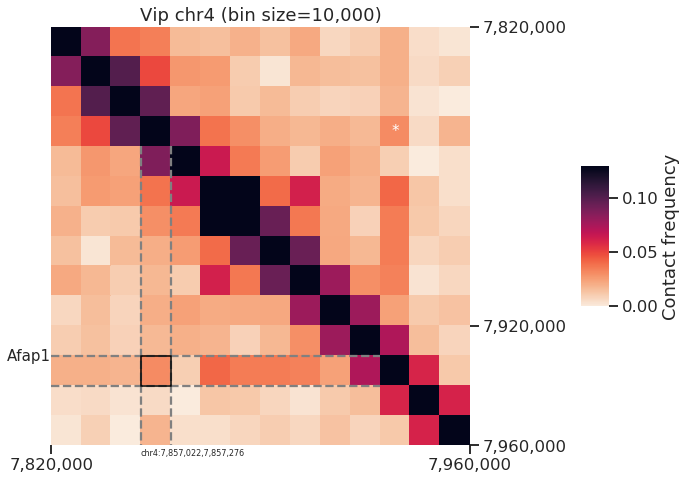

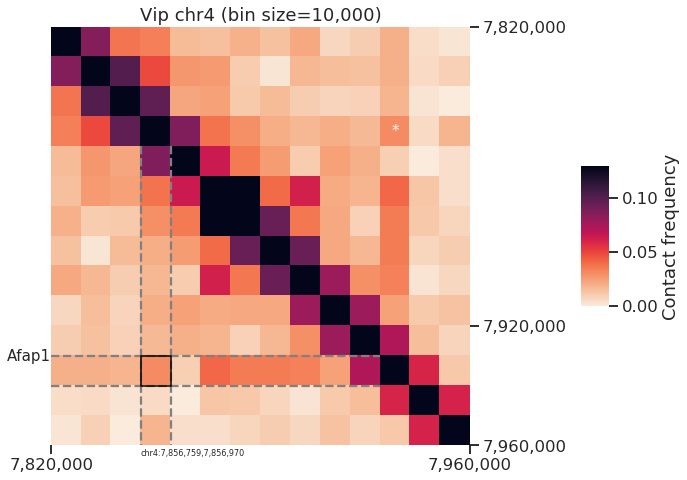

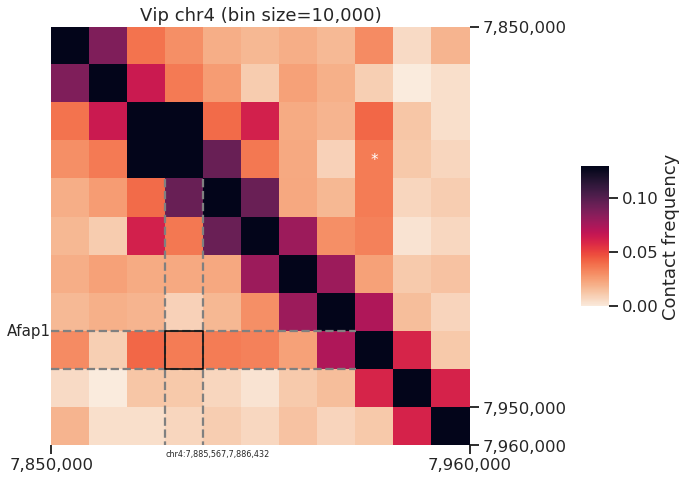

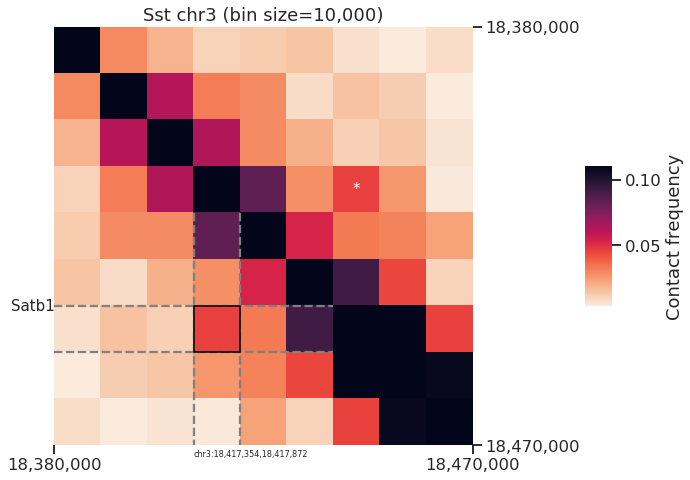

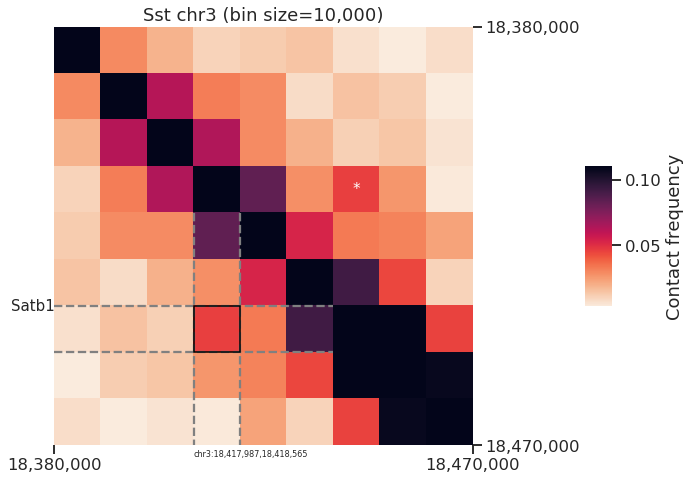

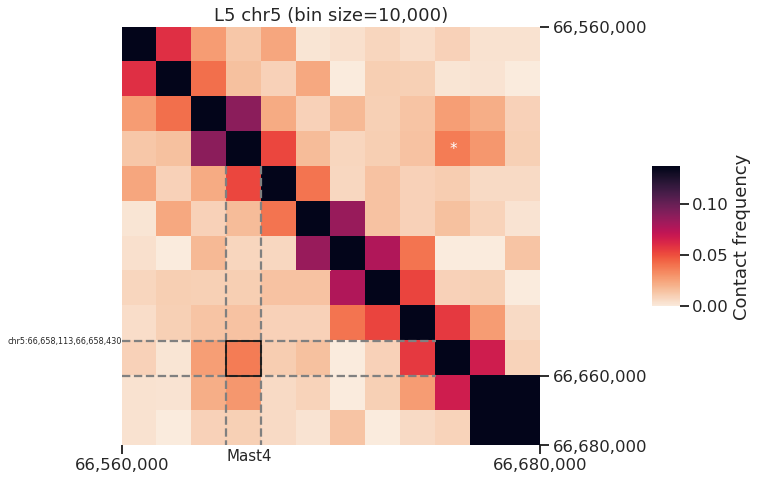

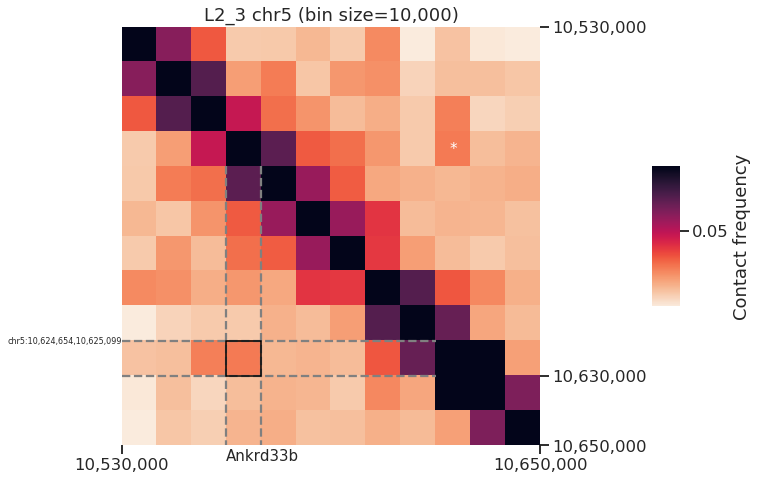

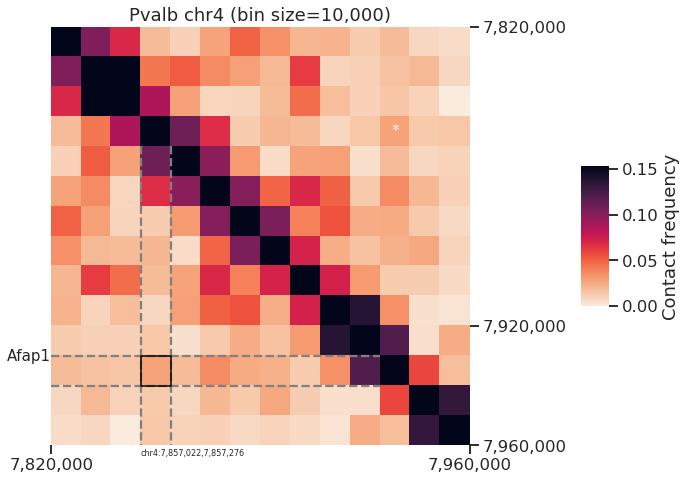

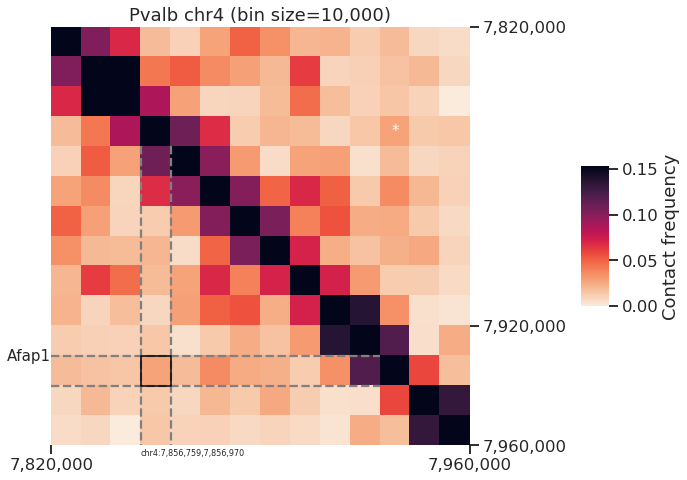

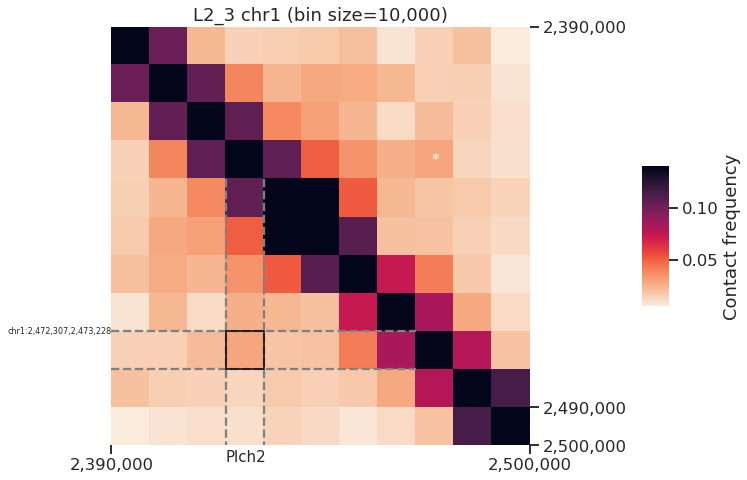

In [21]:
for i, (idx, row) in enumerate(candidates_pair_all
                               .sort_values('fc', ascending=False)
                               .iterrows()):
    if i < 10:
        enh_bin = row['enh_bin']
        gene_bin = row['gene_bin']
        gene_name = df_genes.loc[row['gene'], 'gene_name']
        enh_name = "{}:{:,},{:,}".format(row['enh_chr'], row['enh_start'], row['enh_end'])
        celltype = row['celltype']
        chromosome = row['gene_chr']
        resolution = 10000
        
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)
        
        plot_mat(mat_all, enh_bin, gene_bin, enh_name, gene_name)
    

# some stats - which gene links the most ...

In [22]:
print(candidates_pair_all.shape)
candidates_pair_all.sort_values('fc', ascending=False).head()

(168, 15)


,dist_bin,gene,enh,dist,gene_chr,gene_start,gene_end,enh_chr,enh_start,enh_end,enh_center,enh_bin,gene_bin,fc,celltype
139,8,ENSMUSG00000029094,169789,50545,chr4,7939923,7939924,chr4,7857022,7857276,7857149.0,785,793,2.653373,Vip
140,8,ENSMUSG00000029094,169790,50778,chr4,7939923,7939924,chr4,7856759,7856970,7856864.5,785,793,2.653373,Vip
138,5,ENSMUSG00000029094,169781,38149,chr4,7939923,7939924,chr4,7885567,7886432,7885999.5,788,793,2.354086,Vip
108,3,ENSMUSG00000023927,100766,27398,chr3,18445658,18445659,chr3,18417354,18417872,18417613.0,1841,1844,2.274242,Sst
109,3,ENSMUSG00000023927,100767,26774,chr3,18445658,18445659,chr3,18417987,18418565,18418276.0,1841,1844,2.274242,Sst


In [23]:
candidates_pair_all.groupby('celltype').size().sort_values(ascending=False)

celltype
Sst      28
L5       26
L4       24
Pvalb    22
L2_3     22
Vip      21
Ndnf     19
L6        6
dtype: int64

In [24]:
candidates_pair_all.groupby('gene_chr').size().sort_values(ascending=False).head(10)

gene_chr
chr3     24
chr2     22
chr4     21
chr7     16
chr5     16
chr11    14
chr1     14
chr8     11
chr20     5
chr6      5
dtype: int64

In [25]:
_tmp = candidates_pair_all.groupby('gene').size().sort_values(ascending=False).reset_index() #.head(10)
_tmp['gene_name'] = df_genes.reindex(_tmp['gene'])['gene_name'].values
_tmp.head(30)

,gene,0,gene_name
0,ENSMUSG00000023927,18,Satb1
1,ENSMUSG00000029094,9,Afap1
2,ENSMUSG00000033730,8,Egr3
3,ENSMUSG00000029168,7,Dpysl5
4,ENSMUSG00000037736,6,Limch1
5,ENSMUSG00000042429,6,Adora1
6,ENSMUSG00000034751,6,Mast4
7,ENSMUSG00000004151,6,Etv1
8,ENSMUSG00000022237,5,Ankrd33b
9,ENSMUSG00000032020,4,Ubash3b


# check specfic pairs 

### A specific gene -- Stim2 doesn't quite work (first foray)

In [26]:
# gene_name = 'Stim2'
# gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

# linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
# print(linked_pairs_todo.shape)

# chromosomes_spec = tss_list.set_index('gid').loc[[gene_id], 'chr'].values
# print(chromosomes_spec)

In [27]:
# active_th = 0.5
# # distances
# distance_cutoff = 1e5
# distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
# distances = distance_idx * resolution

# resolution = 10000
# # celltype = "L2_3"
# # chromosome = "chr1"

# # get a list of candidate pairs
# candidates_pair_specific = []
    
# for celltype in tqdm.tqdm(celltypes):
#     for chromosome in tqdm.tqdm(chromosomes_spec):
#         # read in the matrix 
#         resource_string = (
#              '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
#              '::/resolutions/{}'.format(celltype, resolution)
#              )
#         c = cooler.Cooler(resource_string)
#         mat_all = c.matrix(balance=True).fetch(chromosome)

#         # all enhancers and tss on that chromosomes
#         enhs = enh_list[enh_list['chr']==chromosome]
#         tsss = tss_list[tss_list['chr']==chromosome]
#         # only include the gene if it is actively expressed (>50% across cell types)
#         active_genes = gene_rna_clsts_broad_rank[gene_rna_clsts_broad_rank[celltype]>active_th].index.values
#         tsss = tsss[tsss['gid'].isin(active_genes)]

#         # get paired bins
#         paired_bin_tables = collections.OrderedDict({
#             'linked': enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution),
#         })
#         track_names = list(paired_bin_tables.keys())

#         # contact stats: distance bin by corr values in that bin
#         (_contacts, _contacts_sig_pairs
#         ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)
        
#         print(len(_contacts_sig_pairs['linked']))

#         # distance_idx starts from 1, not 0
#         for i, (dist_idx, corr_bin_bck, corr_bin) in enumerate(zip(distance_idx, _contacts, _contacts_sig_pairs['linked'])):

#             if len(corr_bin) > 0:
#                 contacts_p95 = np.nanpercentile(corr_bin_bck, 95)
#                 pairs = paired_bin_tables['linked'].loc[dist_idx].copy().reset_index() #[cond] 
#                 fc = corr_bin/contacts_p95
#                 pairs['fc'] = fc

#                 # this is the most imoportant line: ignore filter by fc>1
#                 # contact frequency greater than 95 percentile in that distance bin
#                 #  candidates_pair = pairs[pairs['fc']>1].copy()
#                 candidates_pair = pairs.copy()
#                 candidates_pair['celltype'] = celltype
#                 candidates_pair_specific.append(candidates_pair)
            
# candidates_pair_specific = pd.concat(candidates_pair_specific, ignore_index=True)
# print(candidates_pair_specific.shape)

In [28]:
# for i, (idx, row) in enumerate(candidates_pair_specific
#                                .sort_values('fc', ascending=False)
#                                .iterrows()):
#     if i < 10:
#         enh_bin = row['enh_bin']
#         gene_bin = row['gene_bin']
#         gene_name = df_genes.loc[row['gene'], 'gene_name']
#         enh_name = "{}:{:,},{:,}".format(row['enh_chr'], row['enh_start'], row['enh_end'])
#         celltype = row['celltype']
#         chromosome = row['gene_chr']
#         resolution = 10000
        
#         resource_string = (
#              '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
#              '::/resolutions/{}'.format(celltype, resolution)
#              )
#         c = cooler.Cooler(resource_string)
#         mat_all = c.matrix(balance=True).fetch(chromosome)
        
#         plot_mat(mat_all, enh_bin, gene_bin, enh_name, gene_name)
    

### A specific gene -- Stim2 promising!

In [36]:
gene_name = 'Stim2'

try:
    gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

    linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
    chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']

    print(linked_pairs_todo.shape)
    print(chromosome_spec)
except:
    print("{} skipped".format(gene_name))
#         continue

# get a list of candidate pairs
chromosome = chromosome_spec
# all enhancers and tss on that chromosomes
enhs = enh_list[enh_list['chr']==chromosome]
tsss = tss_list[tss_list['chr']==chromosome]
# get paired bins
paired_bin_table = enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution)

# try it all a gene list
# plot all 8 cell types?
gene_bin = paired_bin_table['gene_bin'].iloc[0]
chromosome = chromosome_spec
enh_bins = np.sort(paired_bin_table['enh_bin'].values)
enh_names = ["{}:{:,},{:,}".format(row['enh_chr'], row['enh_start'], row['enh_end'])
             for (_chr, _start, _end) in zip(paired_bin_table['enh_chr'], 
                                             paired_bin_table['enh_start'], 
                                             paired_bin_table['enh_end'])
            ]
resolution = 10000

mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all

(5, 3)
chr4


100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


8it [00:01,  6.08it/s]


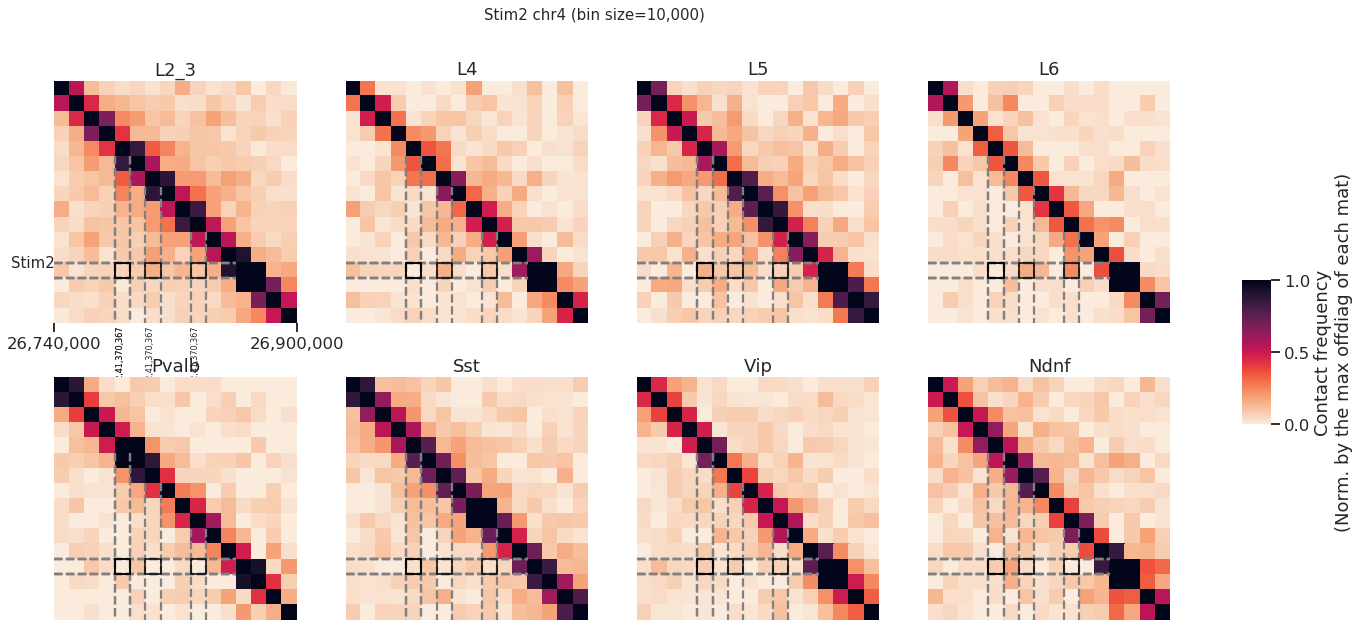

In [38]:
cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
              'label': "Contact frequency\n(Norm. by the max offdiag of each mat)",
              'ticks': [0, 0.5, 1],
           }

pad_ratio = 0.5

fig, axs = plt.subplots(2, 4, figsize=(5*4, 5*2))
cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.2])
for i, (celltype) in tqdm.tqdm(enumerate(celltypes)):
    ax = axs.flat[i]
    if i == 0:
        plot_ticks = True
        cbar = True 
        cbar_ax = cbar_ax
    else:
        plot_ticks = False
        cbar = False
        cbar_ax = cbar_ax
        
    mat_all = mats_all["{} {}".format(celltype, chromosome)]
    ax, g = plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                                  celltype,
                                  pad_ratio=pad_ratio,
                                  plot_ticks=plot_ticks, cbar=cbar, cbar_ax=cbar_ax, cbar_kws=cbar_kws)
    
suptitle = "{} {} (bin size={:,})".format(gene_name, chromosome, resolution)
fig.suptitle(suptitle, y=0.98, fontsize=15)
plt.show()

### Contacts of the most linked genes and the most contacted genes

In [53]:
def routine_specific_genes(gene_name_list, output_tag):
    """
    """
    resolution = 10000
    cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
                  'label': "Contact frequency\n(Norm. by the max offdiag of each mat)",
                  'ticks': [0, 0.5, 1],
               }
    pad_ratio = 0.5 
    
    for gene_name in gene_name_list:
    #     gene_name = 'Stim2'
        try:
            gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

            linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
            chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']

            print(linked_pairs_todo.shape)
            print(chromosome_spec)
        except:
            print("{} skipped".format(gene_name))
        #         continue

        # get a list of candidate pairs
        chromosome = chromosome_spec
        # all enhancers and tss on that chromosomes
        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]
        # get paired bins
        paired_bin_table = enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution)
        paired_bin_table = paired_bin_table[paired_bin_table['enh_bin']!=paired_bin_table['gene_bin']]
        if len(paired_bin_table) == 0:
            print("{} skipped".format(gene_name))
            continue

        # try it all a gene list
        # plot all 8 cell types?
        gene_bin = paired_bin_table['gene_bin'].iloc[0]
        chromosome = chromosome_spec
        enh_bins = np.sort(paired_bin_table['enh_bin'].values)
        enh_names = ["{}:{:,},{:,}".format(row['enh_chr'], row['enh_start'], row['enh_end'])
                     for (_chr, _start, _end) in zip(paired_bin_table['enh_chr'], 
                                                     paired_bin_table['enh_start'], 
                                                     paired_bin_table['enh_end'])
                    ]

        # get data
        mats_all = {}
        for celltype in tqdm.tqdm(celltypes):
            resource_string = (
                 '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
                 '::/resolutions/{}'.format(celltype, resolution)
                 )
            c = cooler.Cooler(resource_string)
            mat_all = c.matrix(balance=True).fetch(chromosome)

            name = "{} {}".format(celltype, chromosome)

            if name not in mats_all.keys(): 
                mats_all["{} {}".format(celltype, chromosome)] = mat_all


        # plot

        fig, axs = plt.subplots(2, 4, figsize=(5*4, 5*2))
        cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.2])
        for i, (celltype) in tqdm.tqdm(enumerate(celltypes)):
            ax = axs.flat[i]
            if i == 0:
                plot_ticks = True
                cbar = True 
                cbar_ax = cbar_ax
            else:
                plot_ticks = False
                cbar = False
                cbar_ax = cbar_ax

            mat_all = mats_all["{} {}".format(celltype, chromosome)]
            ax, g = plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                                          celltype,
                                          pad_ratio=pad_ratio,
                                          plot_ticks=plot_ticks, cbar=cbar, cbar_ax=cbar_ax, cbar_kws=cbar_kws)

        suptitle = "{} (bin size={:,})".format(chromosome, resolution)
        fig.suptitle(suptitle, y=0.98, fontsize=15)

        output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures'
                      'hic_map_{}_{}_{}_{}.pdf'.format(output_tag, gene_name, resolution, today)
                     )
        print(output_fig)
        snmcseq_utils.savefig(fig, output_fig)

        plt.close()
        
        del mats_all

In [54]:
most_correlated_genes = np.array([
    'Rasl11b', 
    'Ankrd33b',
    'Stim2',
#     'Selenon',
    'Grip1os2',
    'Tatdn1',
    'Zdhhc23',
    'Camk2a',
    'Pdp1',
#     'AC158686.2',
    'Ier5',
    'Egr3',
    'Ngef',
    'Phf24',
    'Maf',
    'Dusp6',
    'Rasgrp1',
    'Neurod6',
    'Zfp365',
    'Sox2', 
    'Snap25',
    'Runx2os1',
    'Slc6a1',
    'Ift27',
    'Ctxn1',
    'Lmo4',
]) # genes linked with most number of enhancers

most_contacted_genes = df_genes.reindex(candidates_pair_all.groupby('gene')
                                                            .size()
                                                            .sort_values(ascending=False)
                                                            .head(15).index)['gene_name'].values
print(most_correlated_genes, 
      most_contacted_genes,
     )

['Rasl11b' 'Ankrd33b' 'Stim2' 'Grip1os2' 'Tatdn1' 'Zdhhc23' 'Camk2a' 'Pdp1'
 'Ier5' 'Egr3' 'Ngef' 'Phf24' 'Maf' 'Dusp6' 'Rasgrp1' 'Neurod6' 'Zfp365'
 'Sox2' 'Snap25' 'Runx2os1' 'Slc6a1' 'Ift27' 'Ctxn1' 'Lmo4'] ['Satb1' 'Afap1' 'Egr3' 'Dpysl5' 'Limch1' 'Adora1' 'Mast4' 'Etv1'
 'Ankrd33b' 'Ubash3b' 'Snap25' '4930538E20Rik' 'Adcyap1r1' 'Slc6a1'
 'Neurod6']


  0%|          | 0/8 [00:00<?, ?it/s]

(7, 3)
chr4


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]
8it [00:00,  8.08it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Rasl11b_10000_2020-12-07.pdf


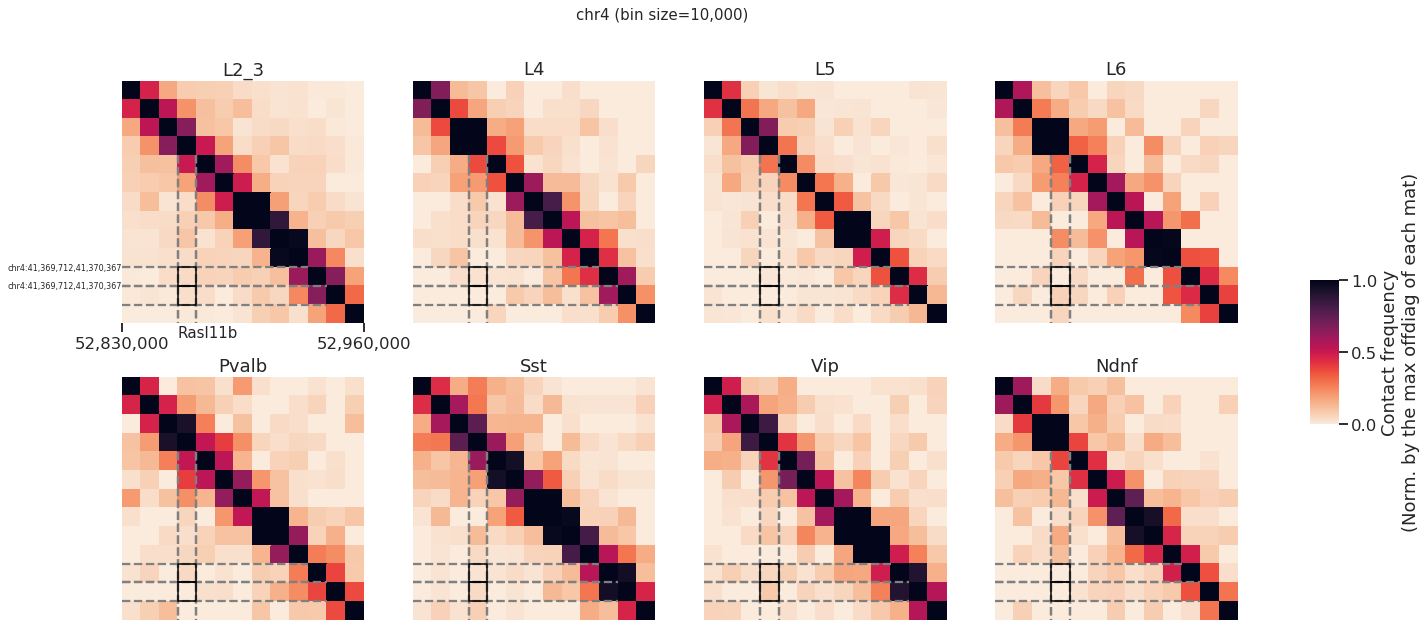

(16, 3)
chr5


100%|██████████| 8/8 [00:19<00:00,  2.49s/it]
8it [00:01,  7.73it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Ankrd33b_10000_2020-12-07.pdf


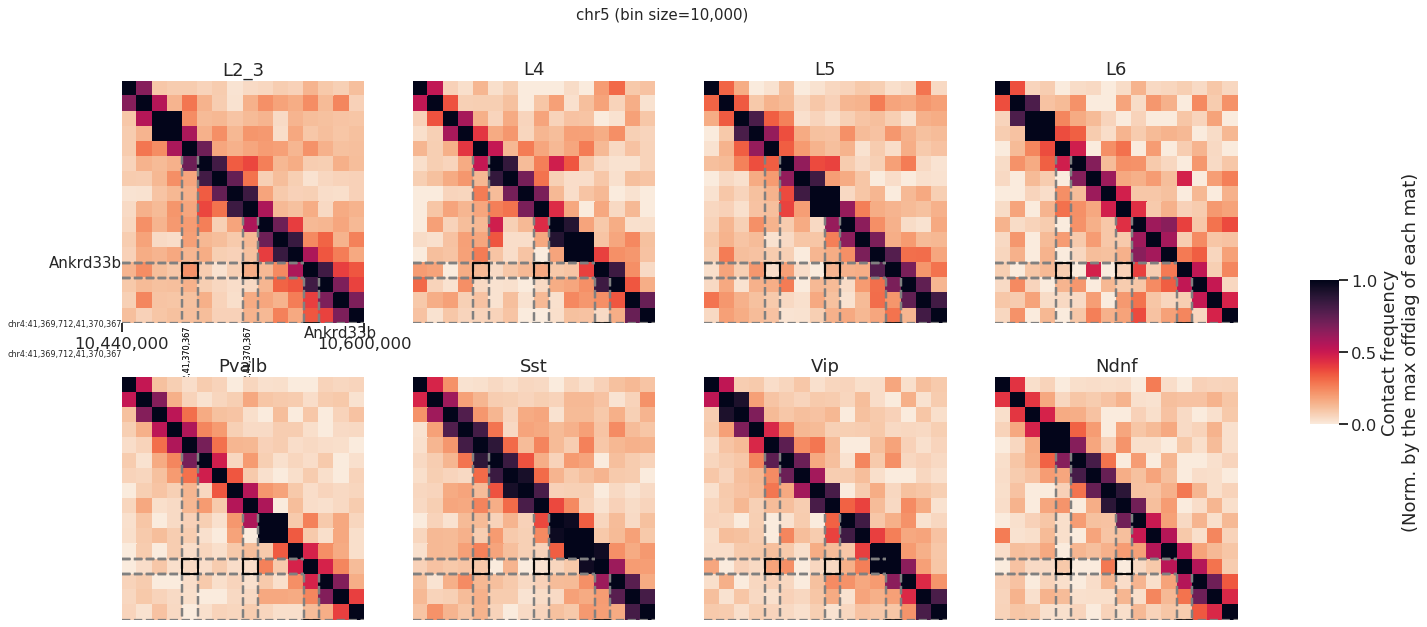

(5, 3)
chr4


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]
8it [00:00,  9.42it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Stim2_10000_2020-12-07.pdf


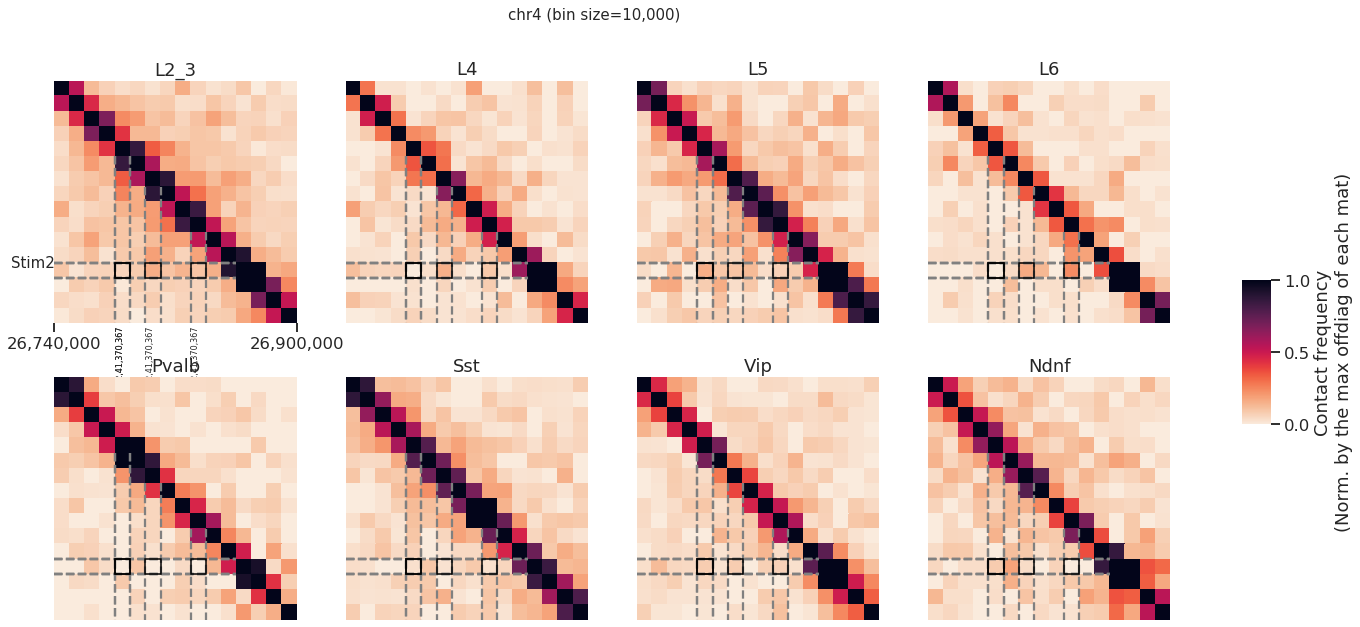

(6, 3)
chr12


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]
8it [00:00,  8.10it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Grip1os2_10000_2020-12-07.pdf


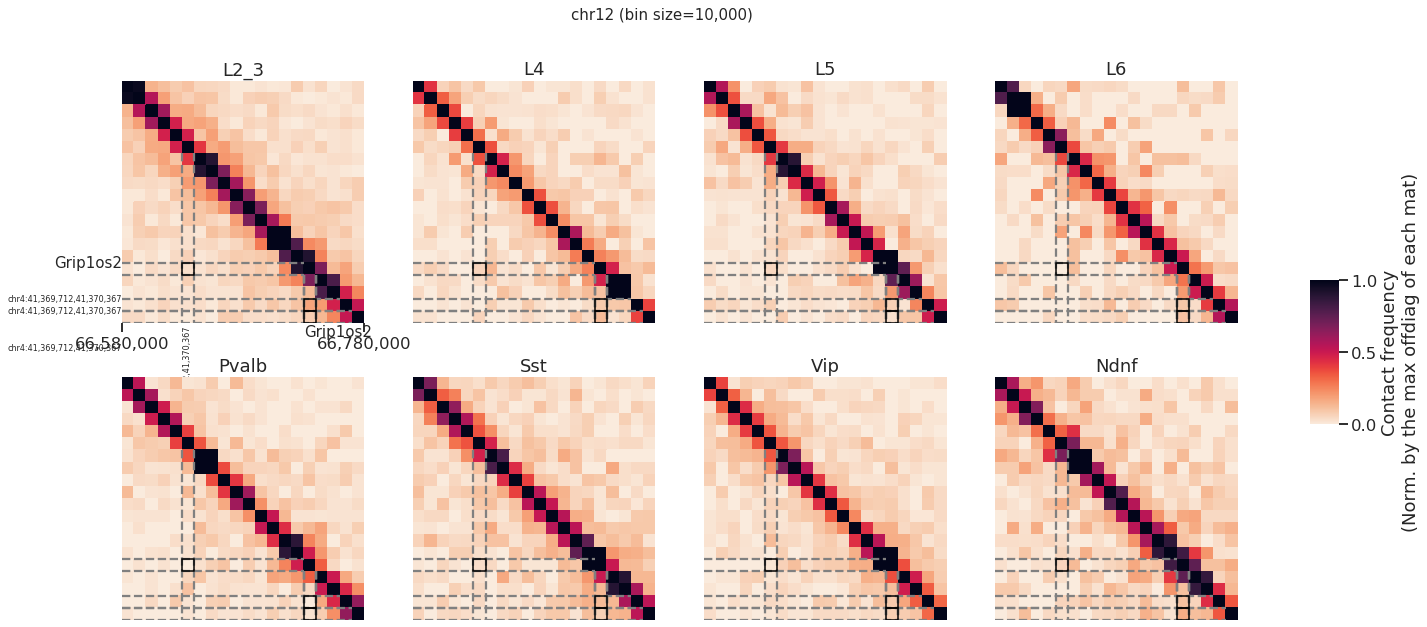

(5, 3)
chr8


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]
8it [00:00,  9.20it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Tatdn1_10000_2020-12-07.pdf


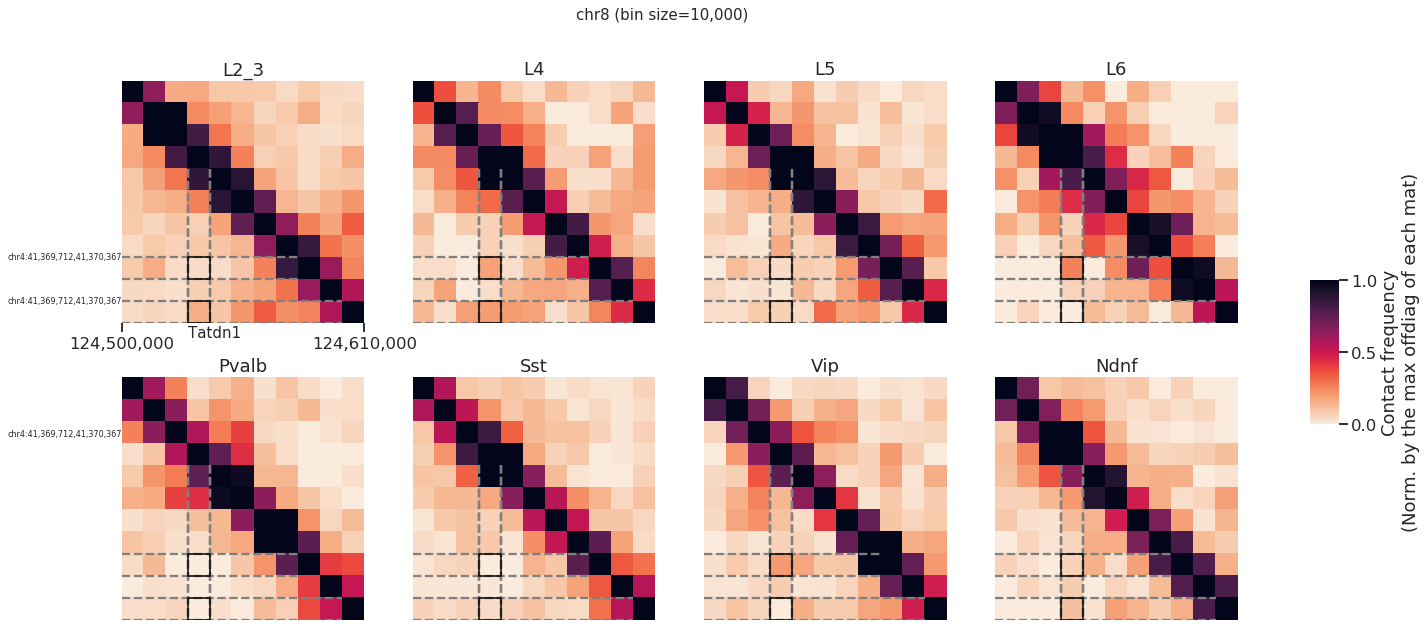

(5, 3)
chr3


100%|██████████| 8/8 [00:23<00:00,  2.97s/it]
8it [00:00,  8.25it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Zdhhc23_10000_2020-12-07.pdf


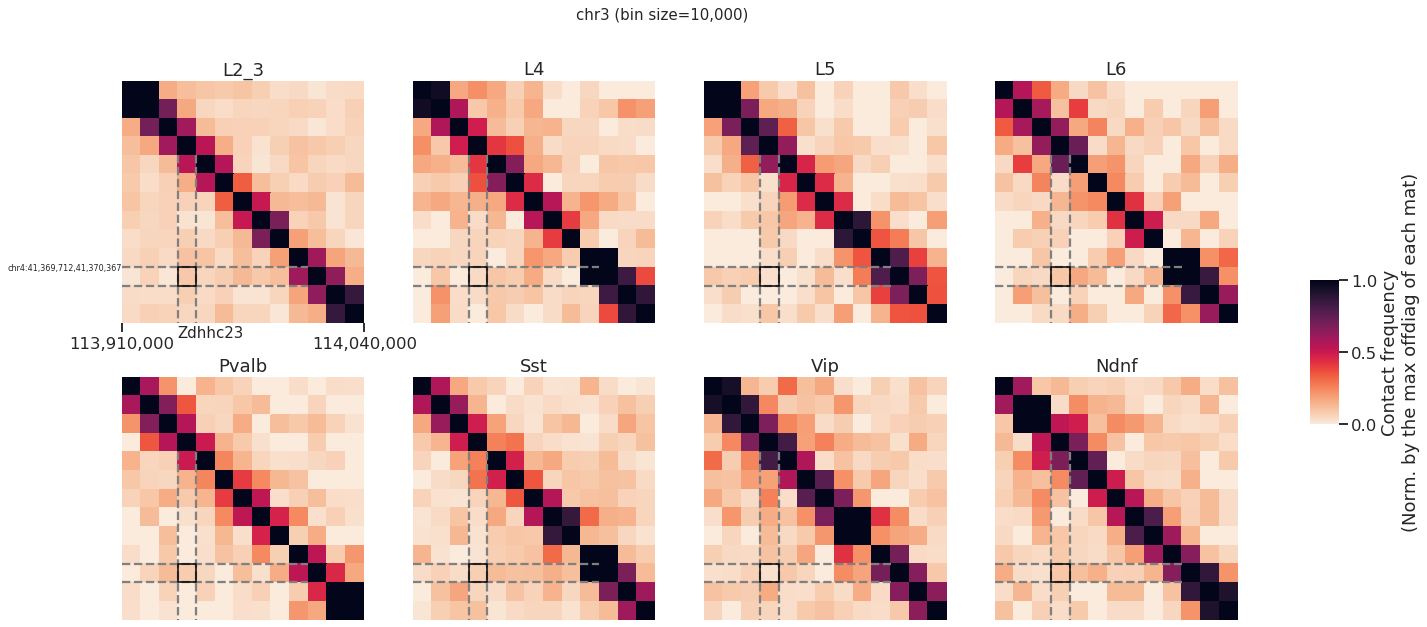

(10, 3)
chr5


100%|██████████| 8/8 [00:19<00:00,  2.49s/it]
8it [00:00,  8.49it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Camk2a_10000_2020-12-07.pdf


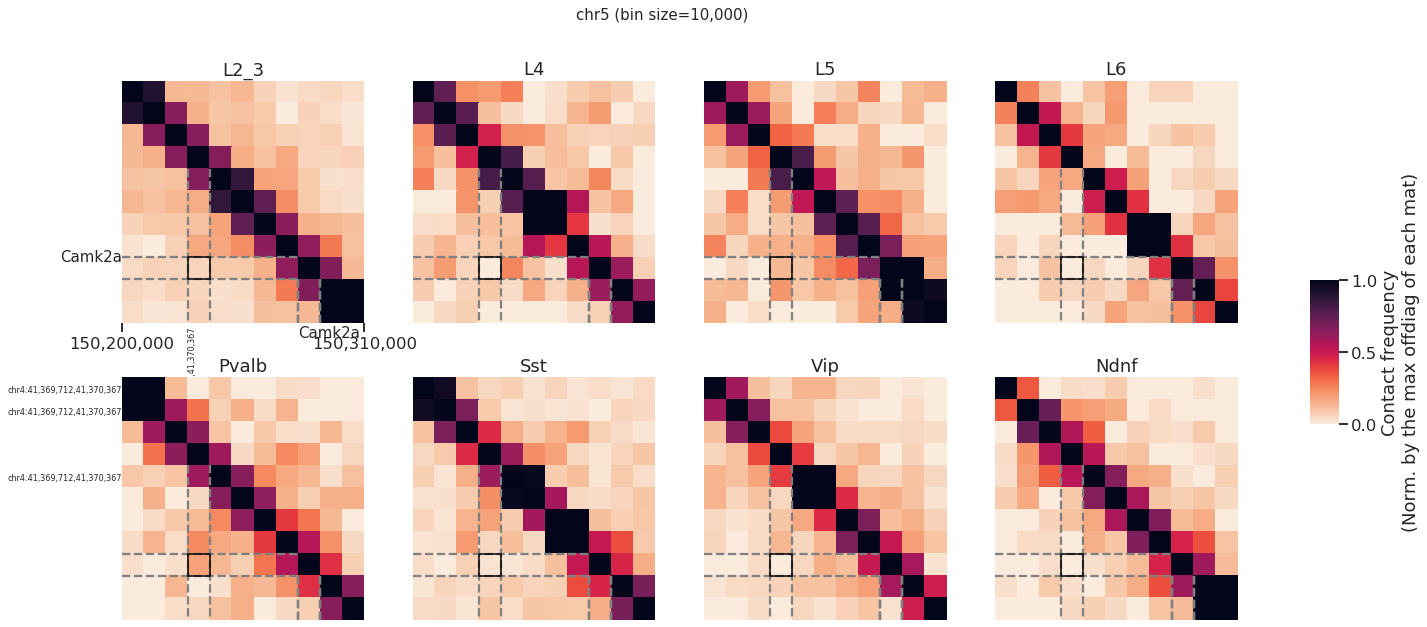

(4, 3)
chr8


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]
8it [00:01,  7.50it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Pdp1_10000_2020-12-07.pdf


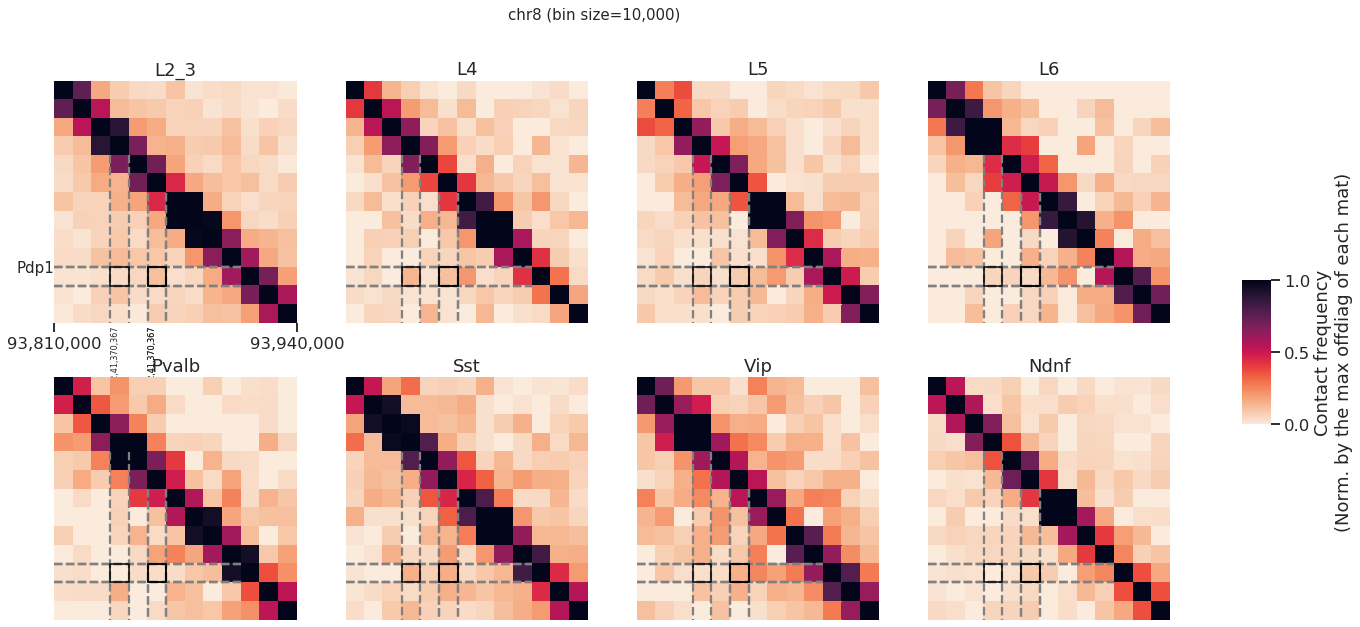

(4, 3)
chr1


100%|██████████| 8/8 [00:50<00:00,  6.31s/it]
8it [00:01,  7.02it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Ier5_10000_2020-12-07.pdf


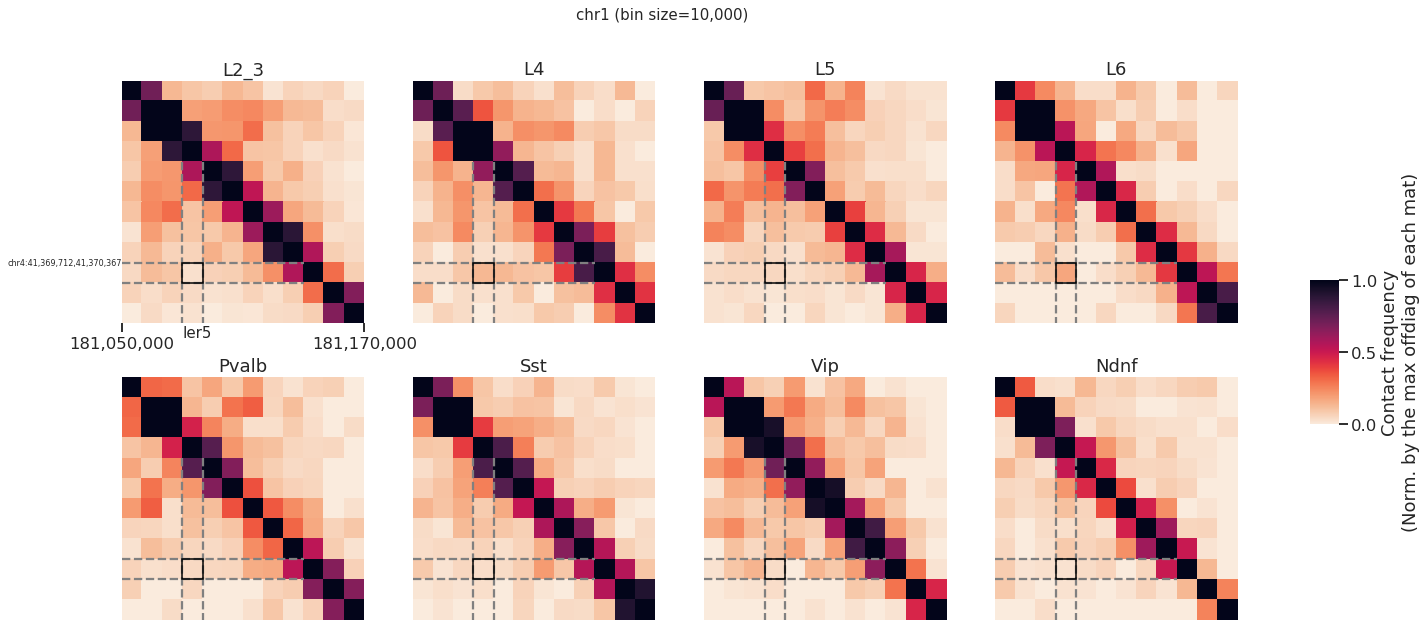

(4, 3)
chr8


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]
8it [00:02,  3.09it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Egr3_10000_2020-12-07.pdf


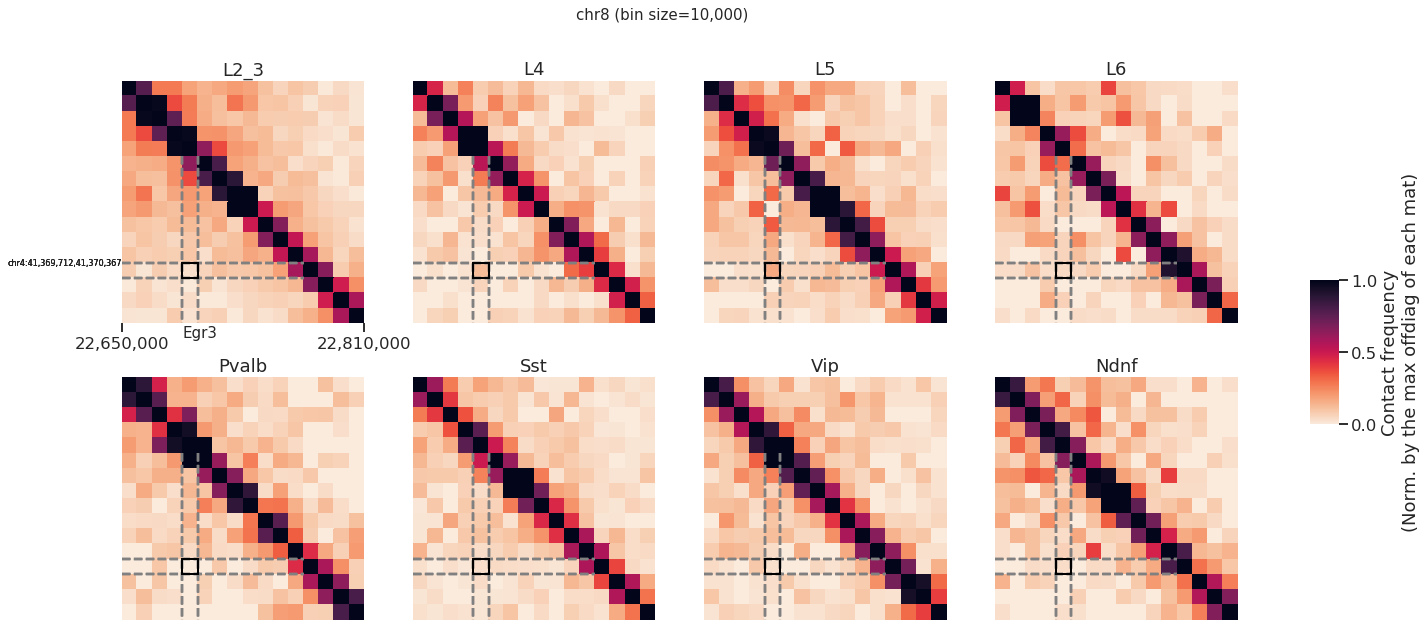

(7, 3)
chr2


100%|██████████| 8/8 [00:34<00:00,  4.33s/it]
8it [00:00,  9.69it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Ngef_10000_2020-12-07.pdf


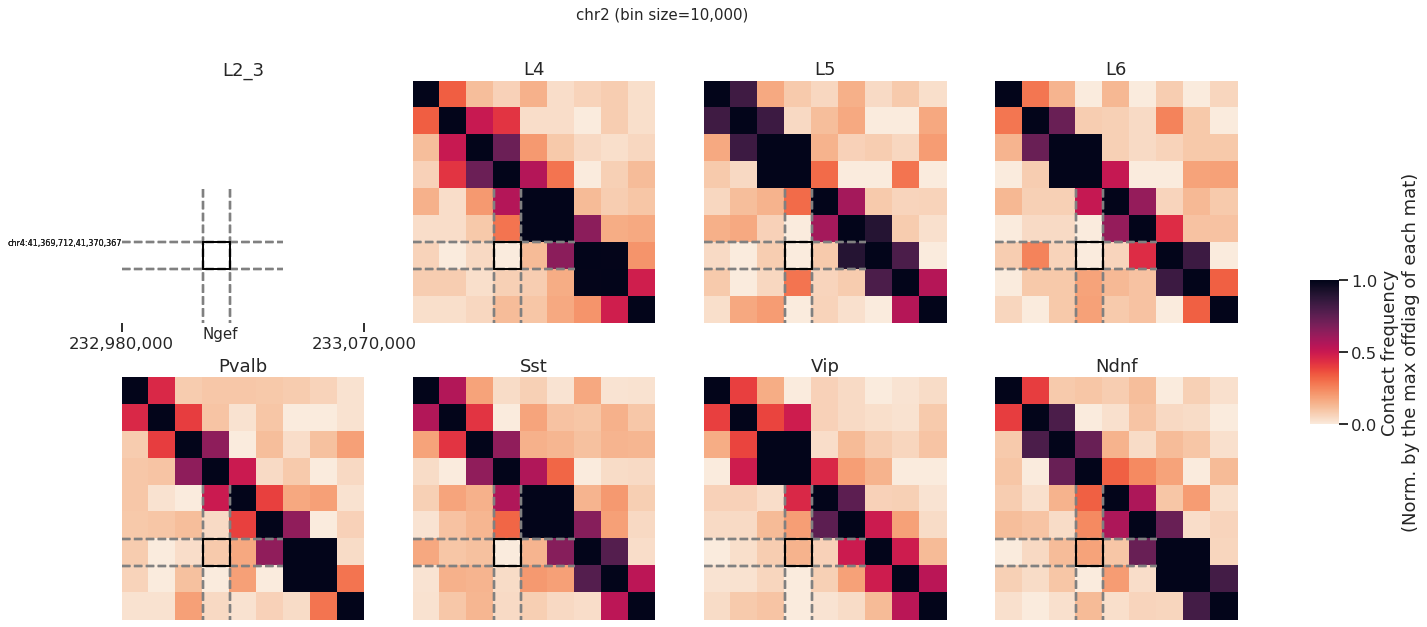

(4, 3)
chr9


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]
8it [00:00,  8.67it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Phf24_10000_2020-12-07.pdf


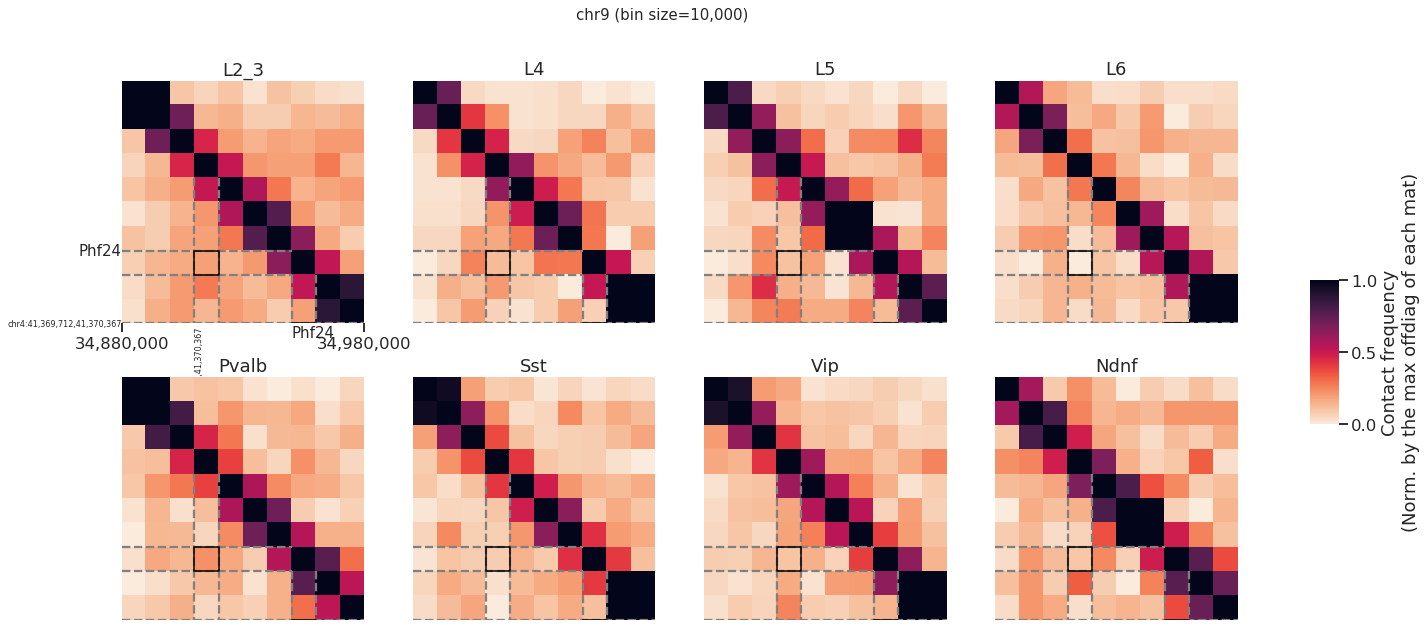

(5, 3)
chr16


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]
8it [00:00,  8.66it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Maf_10000_2020-12-07.pdf


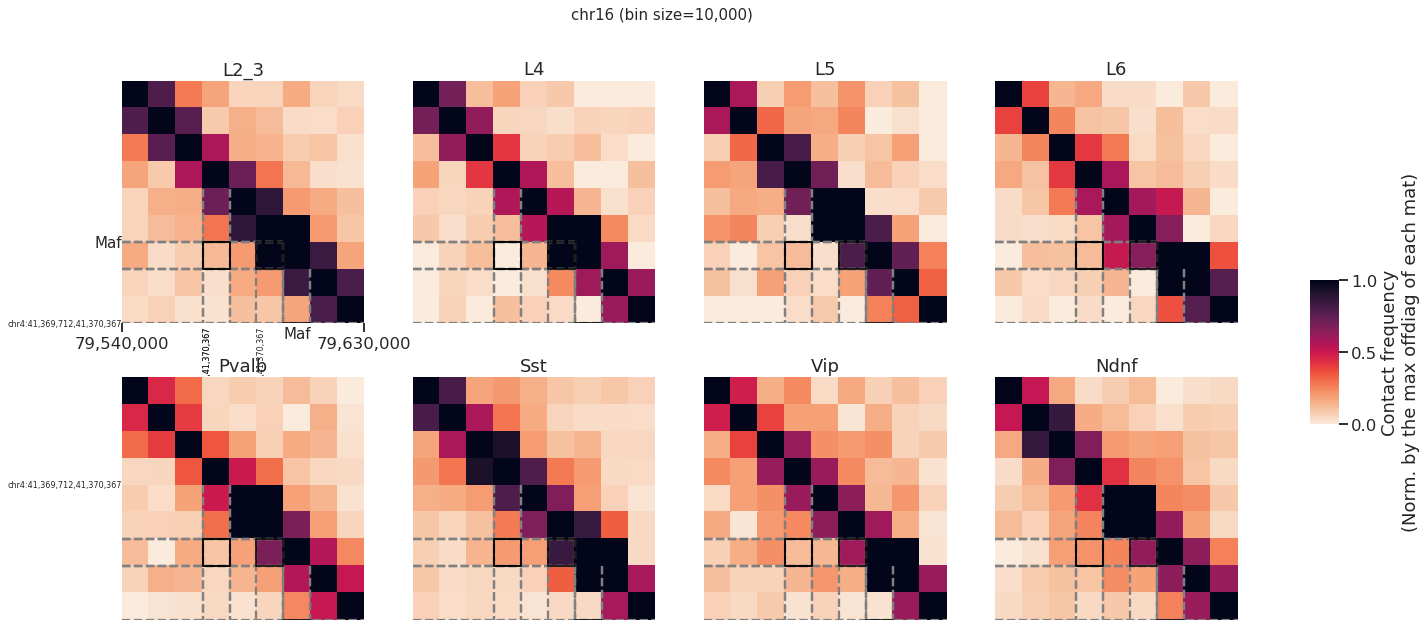

  0%|          | 0/8 [00:00<?, ?it/s]

(4, 3)
chr12


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]
8it [00:01,  6.86it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Dusp6_10000_2020-12-07.pdf


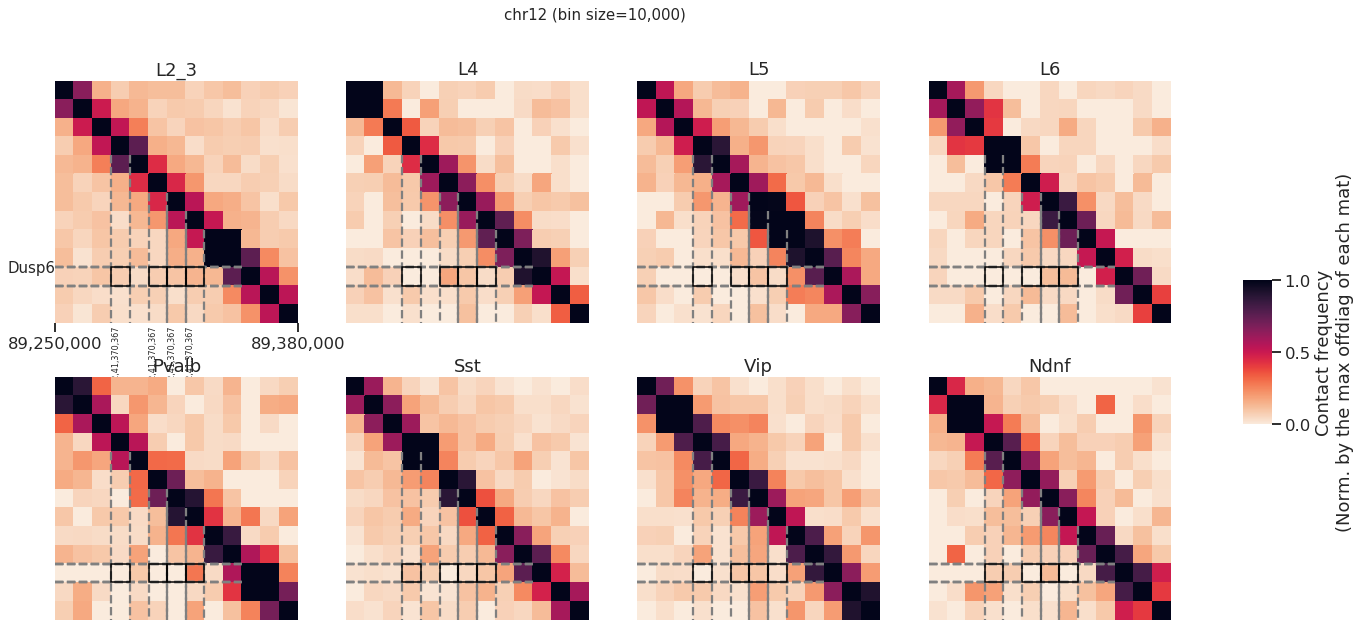

(10, 3)
chr15


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
8it [00:00,  8.17it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Rasgrp1_10000_2020-12-07.pdf


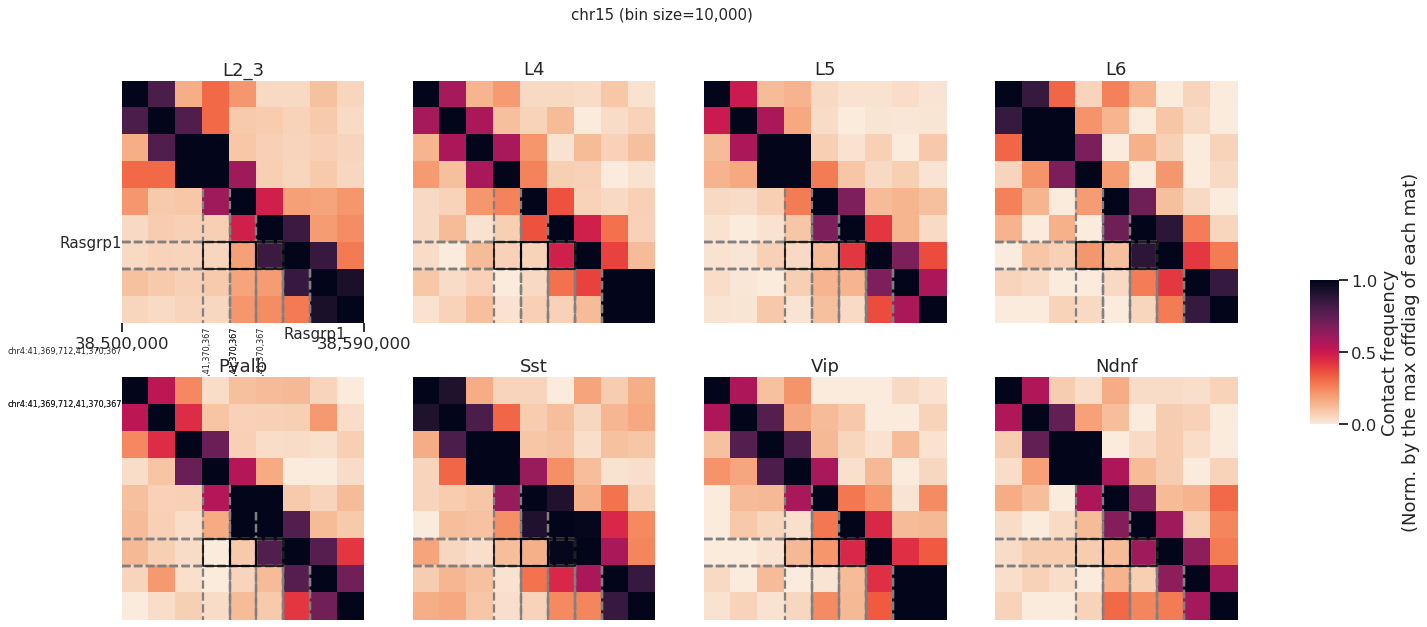

(3, 3)
chr7


100%|██████████| 8/8 [00:15<00:00,  2.00s/it]
8it [00:00,  9.59it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Neurod6_10000_2020-12-07.pdf


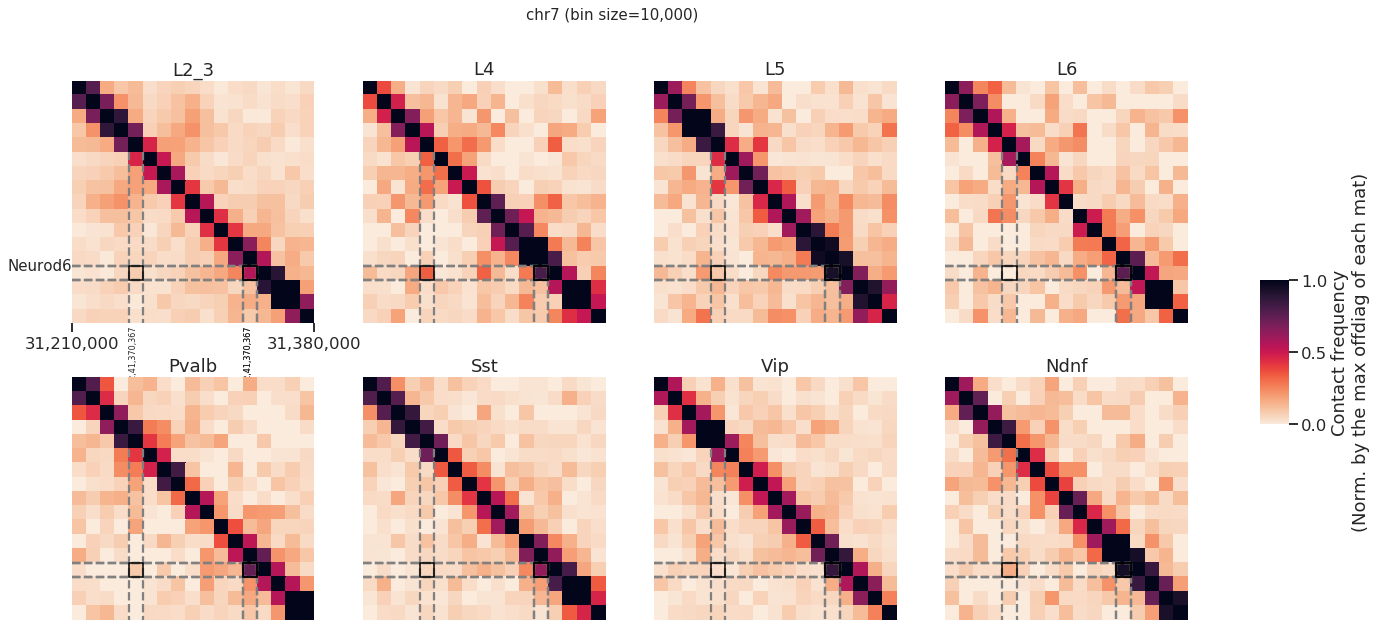

(3, 3)
chr10


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]
8it [00:00,  9.98it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Zfp365_10000_2020-12-07.pdf


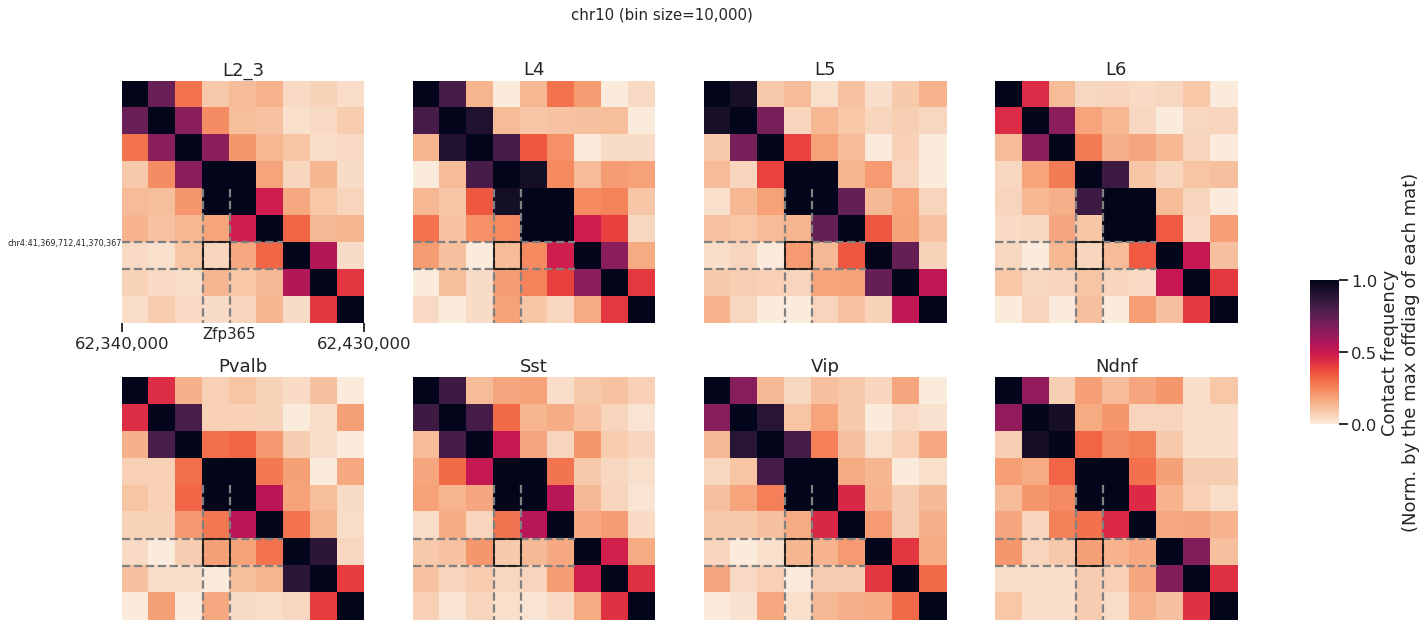

(3, 3)
chr3


100%|██████████| 8/8 [00:23<00:00,  2.97s/it]
8it [00:00,  8.93it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Sox2_10000_2020-12-07.pdf


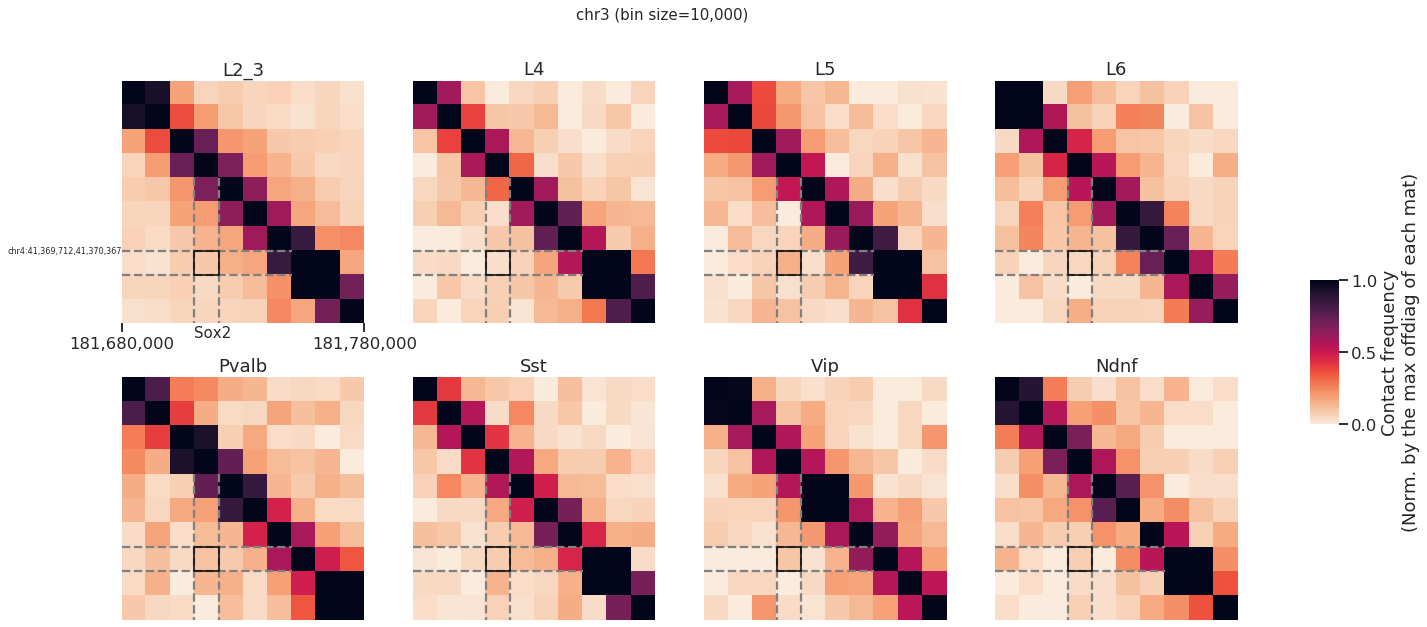

(3, 3)
chr20


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]
8it [00:00,  8.59it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Snap25_10000_2020-12-07.pdf


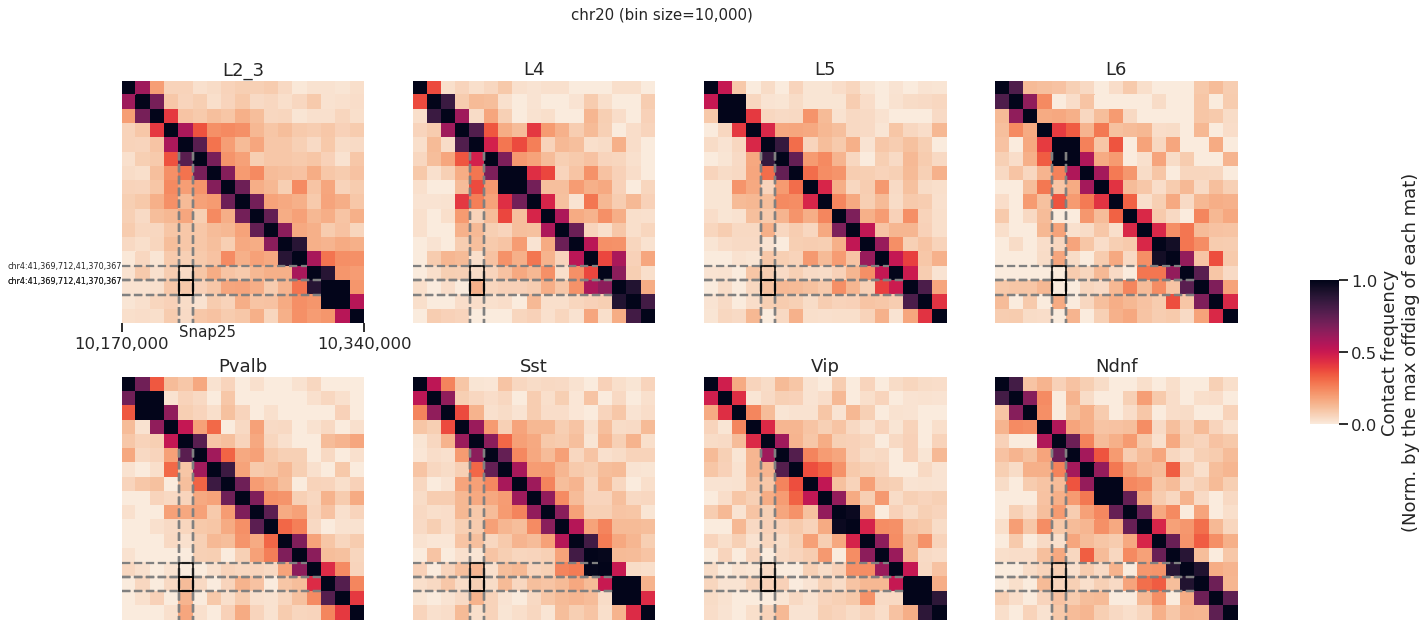

  0%|          | 0/8 [00:00<?, ?it/s]

(3, 3)
chr6


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]
8it [00:01,  7.58it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Runx2os1_10000_2020-12-07.pdf


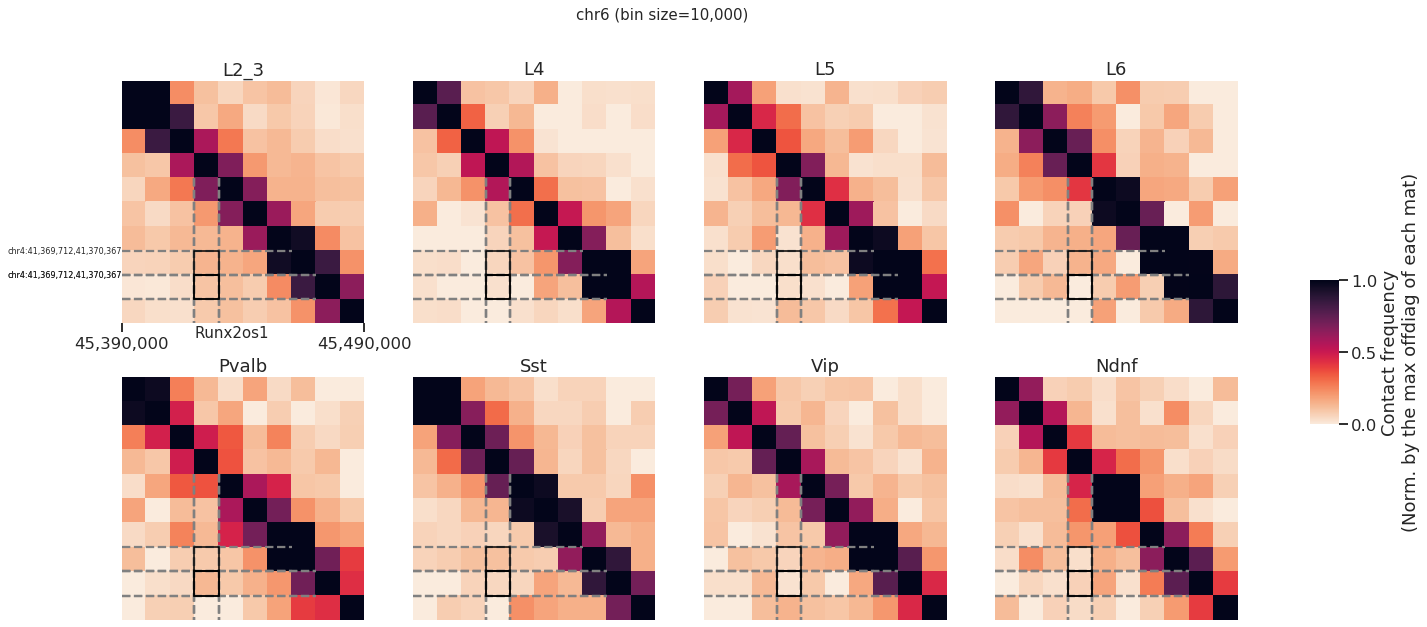

(8, 3)
chr3


100%|██████████| 8/8 [00:23<00:00,  2.99s/it]
8it [00:00,  9.98it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Slc6a1_10000_2020-12-07.pdf


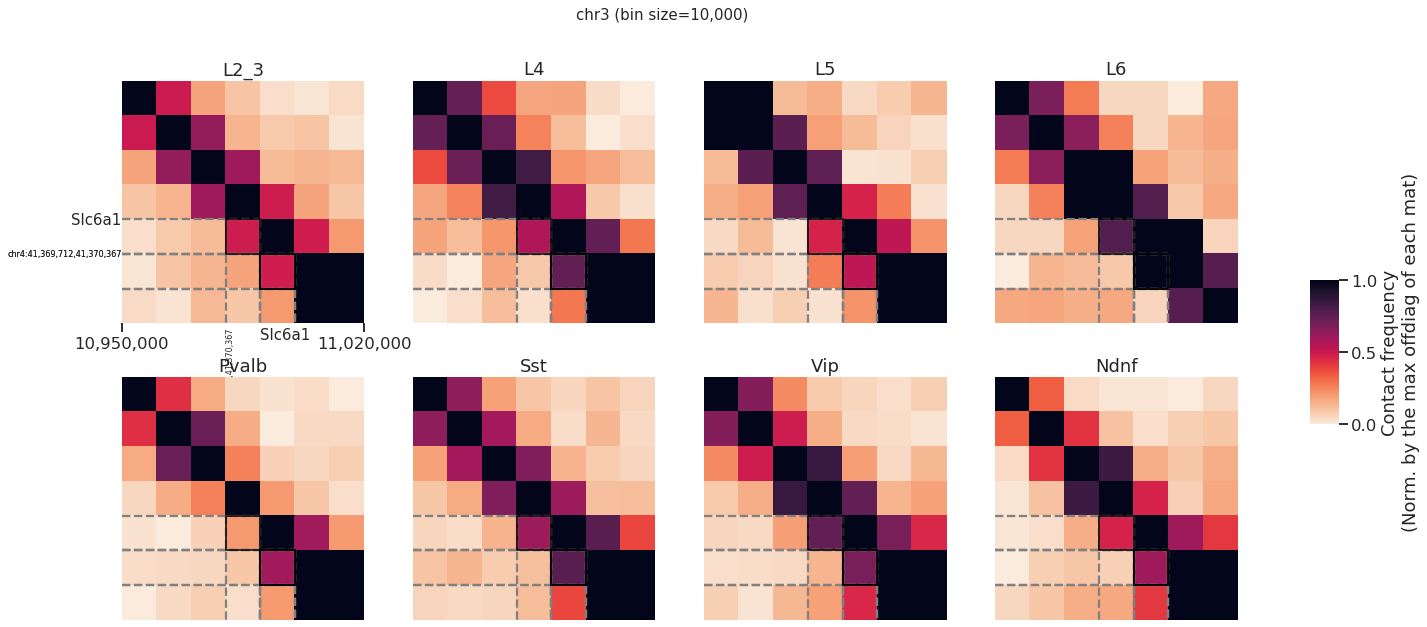

(3, 3)
chr22


100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
8it [00:01,  7.38it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Ift27_10000_2020-12-07.pdf


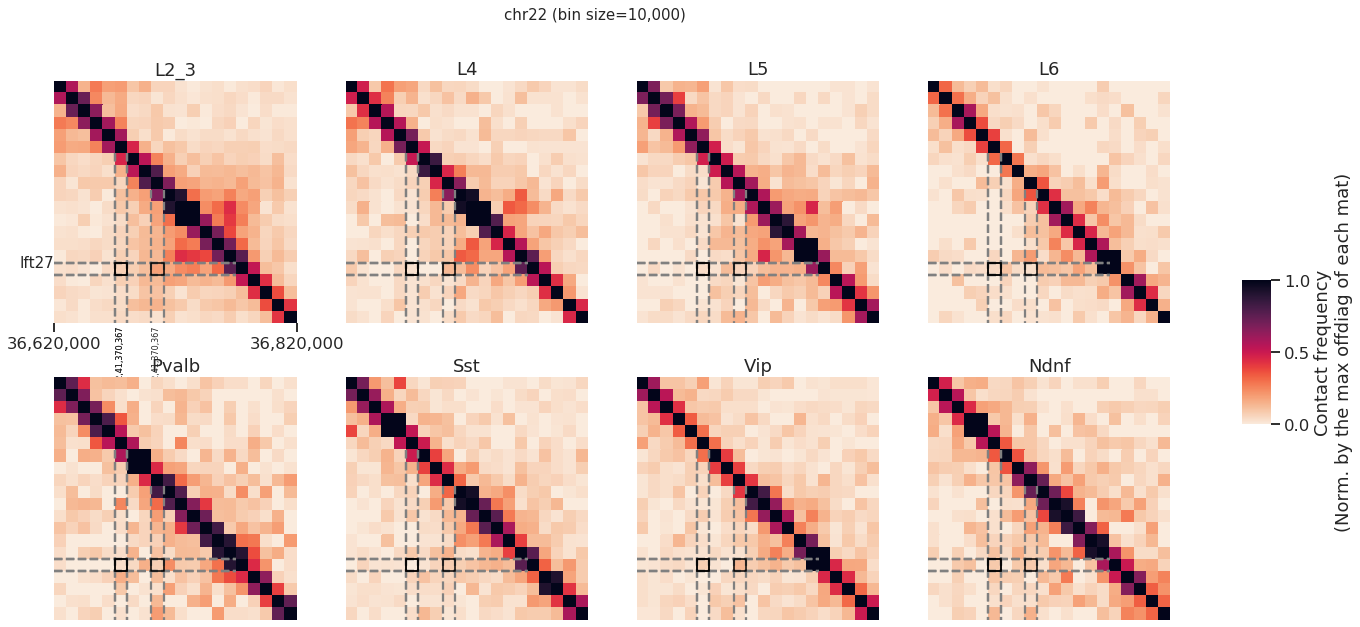

  0%|          | 0/8 [00:00<?, ?it/s]

(3, 3)
chr19
Ctxn1 skipped
(4, 3)
chr1


100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
8it [00:01,  7.92it/s]


/cndd2/fangming/projects/scf_enhancers/figureshic_map_correlated_genes_Lmo4_10000_2020-12-07.pdf


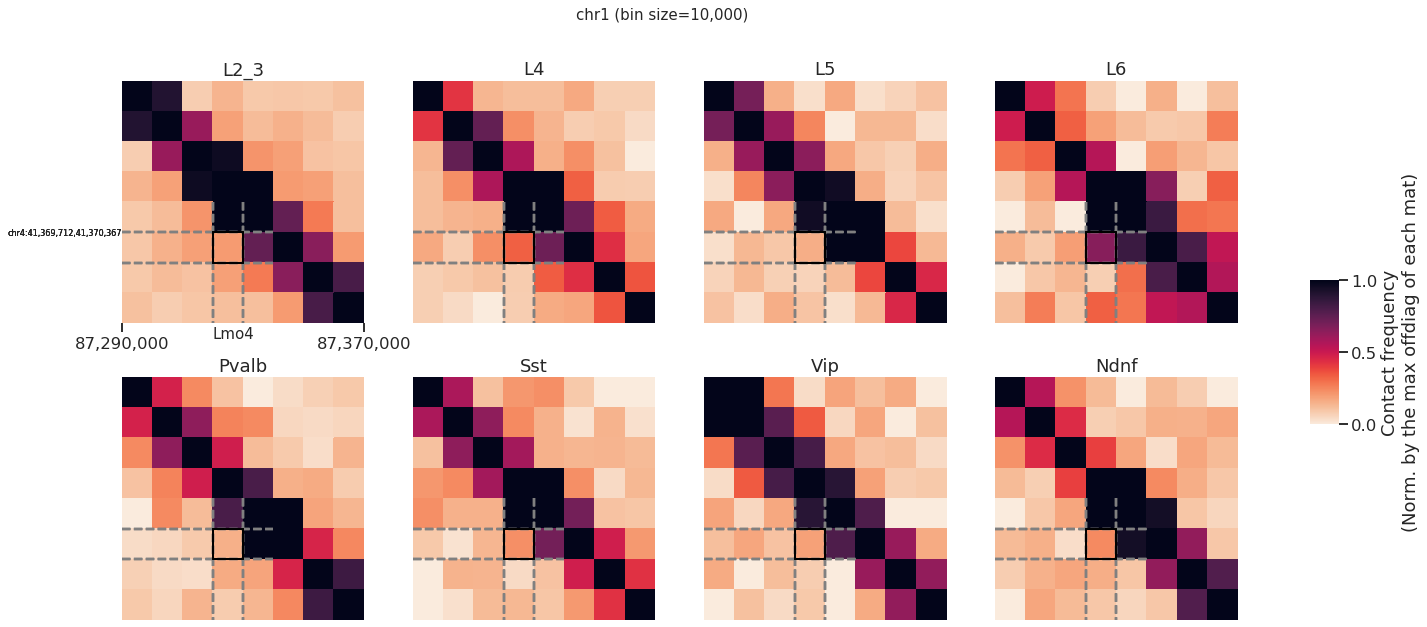

In [47]:
output_tag = 'correlated_genes'
routine_specific_genes(most_correlated_genes, output_tag)

In [55]:
output_tag = 'contacted_genes'
routine_specific_genes(most_contacted_genes, output_tag)

  0%|          | 0/8 [00:00<?, ?it/s]

(9, 3)
chr3


  0%|          | 0/8 [00:01<?, ?it/s]


MemoryError: 